# Project part 1

In [1]:
# Import libraries
import glob
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
pd.options.mode.chained_assignment = None 
import requests
from difflib import SequenceMatcher
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
import scipy
import os
import json
import folium
import seaborn
import matplotlib.pyplot as plt
from branca.colormap import linear
import branca.colormap as cm
from IPython.display import HTML


## Preparing data

The data we use is listed on Swiss open data. The actual data and further desciptions are given on Open Data Zurich. For the project we consider the following data sets:

1) "Umzüge nach Stadtquartier, Geschlecht, Altersgruppe und Zivilstand, seit 1993" lists all moves between districts of the City of Zurich since 1993 by district, gender, age group and marital/civil status

2) "Zuzüge nach Zuzugsort, Stadtquartier, Geschlecht, Altersgruppe und Zivilstand, seit 1993" lists all moves into districts of the City of Zurich from outside since 1993 by place of origin, district, gender, age group and marital/civil status

3) "Wegzüge nach Wegzugsort, Stadtquartier, Geschlecht, Altersgruppe und Zivilstand, seit 1993" lists all moves out of districts of the City of Zurich from outside since 1993 by place of origin, district, gender, age group and marital/civil status

4) "Bevölkerung nach Stadtquartier, Herkunft, Geschlecht und Alter, seit 1993" lists all people living in districts by age, Swiss/foreigh and gender

5) "Bevölkerung nach Nationalität und Stadtquartier, seit 1993" lists number of people and nationalities in each district

6) "Bevölkerung und Anzahl Nationalitäten nach Stadtquartier, seit 1993" lists number of people and nationalities in each district

7) "Median-Vermögen steuerpflichtiger natürlicher Personen nach Jahr, Steuertarif und Stadtquartier" lists the quartile of taxable wealth per tax class for each district

8) "Median-Einkommen steuerpflichtiger natürlicher Personen nach Jahr, Steuertarif und Stadtquartier" lists the quartile of income per tax class for each district

In [12]:
ZH_within_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_umzuege_jahr_quartier_ag_zivilstand/resource/212bc17b-25ac-4c1c-bef0-cedfddaaceb7/download/bev355od3556.csv'

ZH_in_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_zuz_jahr_quartier_ag_zivilstand/resource/aa5020b5-4e21-4c06-897c-478e08277419/download/bev351od3512.csv'

ZH_out_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_wegz_jahr_quartier_ag_zivilstand/resource/7462b6b8-100a-4782-a12b-6649a9f1c249/download/bev352od3522.csv'

ZH_population_1993_URL = 'https://data.stadt-zuerich.ch/dataset/6f8b5279-998b-4000-a5a4-e3addf10c49e/resource/f2384262-e8c8-4d04-91fa-3cbf15e2b673/download/bev390od3903.csv'

ZH_nationalities_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_nationalitaet/resource/10b83df1-b247-467d-a3cb-0b389a758e1a/download/bev336od3361.csv'

ZH_number_nation_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_anz_nationen_quartier/resource/634b6e5a-7143-4eab-9f5d-fb75dd92d5da/download/bev336od3363.csv'

ZH_median_wealth_1999_URL = 'https://data.stadt-zuerich.ch/dataset/f8c9ebd3-629b-450b-9a61-244bcf7ec44b/resource/e4d02782-e6f8-4138-9b41-ac8946ee3327/download/wir100od1004.csv'

ZH_median_income_1999_URL = 'https://data.stadt-zuerich.ch/dataset/63e0caf8-a46c-4aec-ad13-d1803d448f9c/resource/0c67045f-ce8d-4dff-b1e3-2263524f96f4/download/wir100od1007.csv'

#Defining the data frames
#ZH_within_df=pd.read_csv(ZH_within_1993_URL)
#ZH_in_df=pd.read_csv(ZH_in_1993_URL)
#ZH_out_df=pd.read_csv(ZH_out_1993_URL)
#ZH_population_df=pd.read_csv(ZH_population_1993_URL)
#ZH_nationalities_df=pd.read_csv(ZH_nationalities_1993_URL)
#ZH_number_nation_df=pd.read_csv(ZH_number_nation_1993_URL)
#ZH_median_wealth_df=pd.read_csv(ZH_median_wealth_1999_URL)
#ZH_median_income_df=pd.read_csv(ZH_median_income_1999_URL)

ZH_in_df = pd.read_csv('Data/ZH_in.csv')
ZH_within_df = pd.read_csv('Data/ZH_within.csv')
ZH_out_df = pd.read_csv('Data/ZH_out.csv')

all_frames = [ZH_in_df, ZH_within_df, ZH_out_df]
ZH_popul = pd.read_csv('Data/ZH_popul_Total.csv')
ZH_popul_CH = pd.read_csv('Data/ZH_popul_CH.csv')

In [ ]:
# Grouping all frames
all_frames = [ZH_in_df, ZH_within_df, ZH_out_df, ZH_population_df,
              ZH_nationalities_df, ZH_number_nation_df, 
              ZH_median_wealth_df, ZH_median_income_df]

# Translating column names for individual frames
# Stadtquartier translated as district
# Kreis translated as council
ZH_within_df.columns = ['Year', 
                       'district_from_code', 'district_from_name', 'council_from_code',
                       'district_to_code', 'district_to_name', 'council_to_code',
                       'age_group_code', 'age_group', 'gender', 
                       'marital_code', 'marital_status', 'Total']

#Bezirk translated as county
ZH_in_df.columns = ['Year', 
                    'county_from_code', 'county_from_name', #foreigner for non-Swiss
                    'canton_from_code', 'canton_from_name', #foreigner for non-Swiss
                    'country_from_code', 'country_from_name', 
                    'subcontinent_from_code', 'subcontinent_from_name', 
                    'continent_from_code', 'continent_from_name',
                    'district_to_code', 'district_to_name', 'council_to_code',
                    'age_group_code', 'age_group', 'gender', 
                    'marital_code', 'marital_status', 'Total']

#Bezirk translated as county here
ZH_out_df.columns = ['Year', 
                    'county_to_code', 'county_to_name', #foreigner for non-Swiss
                    'canton_to_code', 'canton_to_name', #foreigner for non-Swiss
                    'country_to_code', 'country_to_name', 
                    'subcontinent_to_code', 'subcontinent_to_name', 
                    'continent_to_code', 'continent_to_name',
                    'district_from_code', 'district_from_name', 'council_from_code',
                    'age_group_code', 'age_group', 'gender', 
                    'marital_code', 'marital_status', 'Total']

ZH_population_df.columns = ['Year', 'district_code', 'district_code2', 'district_name',
                            "age", "age2", "age_group5_code", "age_group5",
                            "CH_nonCH", "CH_nonCH_code", "gender_code", "gender", "Total"]

# Difference between nation_hist and nation exist in case where nations split or united
# e.g. "Serbien, Montenegro, Kosovo" vs "Serbien" (2006), "Montenegro"(2006/07), "Kosovo"(2008)
ZH_nationalities_df.columns = ['Year', 'district_code', 'district_code2', 'district_name',
                             'nation_hist_code', 'nation_hist_name', 'nation_code', 'nation_name',
                             'subcontinent_code', 'subcontinent_name',
                             'continent_code', 'continent_name', 'Total']

ZH_number_nation_df.columns = ['Year', 'district_code', 'district_code2', 'district_name',
                       'Total_pop', 'Total_nat']

ZH_median_wealth_df.columns = ['Year', 'district_code', 'district_name', 
                               'tax_code', 'tax_class', 
                               'tax_wealth_p50', 'tax_wealth_p25', 'tax_wealth_p75']
# Kreis translated as borough, borough = set of districts
ZH_median_wealth_df.columns = ['Year', 'borough_code', 'borough_name', 
                               'tax_code', 'tax_class', 
                               'tax_wealth_p50', 'tax_wealth_p25', 'tax_wealth_p75']

## Replacing the most used German terminology to English terms.

We create dictionaries for the most common terms that appear in the data. Thsi will allow English speaking readers and group members to work with the data.

Comment: At this stage we don't translate all the country names, as we expect that names are rarely called.We may do their translation using a dictionary at a later stage.

In [ ]:
# We make a dictionary of distionary to translate individual categories

# Sample code
# cleanup_nums = {"num_doors":     {"four": 4, "two": 2},
#                 "num_cylinders": {"four": 4, "six": 6, "five": 5, "eight": 8,
#                                   "two": 2, "twelve": 12, "three":3 }}
# obj_df.replace(cleanup_nums, inplace=True)
# obj_df.head()

translation = {"marital_status" : {"Ledig" : "Single", "Verheiratet" : "Married", 
                                    "Geschieden" : "Divorced", "Verwitwet" : "Widow", 
                                    "In eingetragener Partnerschaft" : "Registered partnership", 
                                    "Aufgelöste Partnerschaft" : "Disolved partnership", 
                                    "Unbekannt" : "Unknown"},
               "tax_class" :       {"Grundtarif" : "base rate",
                                    "Verheiratetentarif" : "couple rate",
                                    
                                    "Einelternfamilientarif" : "single parent family rate"},
               "gender" :          {"W":"F"}}
translation_global = {"Ausland" : "Foreign", "Ausländer/in" : "Foreign",
                      "Schweizer/in" : "Swiss", "Unbekannt" : "Unknown",
                      "Unzuteilbar" : "Undetermined", "100 u. älter" : "99+"}

for frame in all_frames:
    frame.replace(translation, inplace=True)
    frame.replace(translation_global, inplace=True)



## Saving the data frames to files in a local drive

We save that data locally, for quicker offline access.

In [ ]:
ZH_in_df.to_csv('Data/ZH_in.csv', encoding='utf-8', index = False)

ZH_out_df.to_csv('Data/ZH_out.csv', encoding='utf-8', index = False)

ZH_within_df.to_csv('Data/ZH_within.csv', encoding='utf-8', index = False)

ZH_population_df.to_csv('Data/ZH_popul.csv', encoding='utf-8', index = False)

ZH_nationalities_df.to_csv('Data/ZH_nationalities.csv', encoding='utf-8', index = False)

ZH_number_nation_df.to_csv('Data/ZH_number_nation.csv', encoding='utf-8', index = False)

ZH_median_wealth_df.to_csv('Data/ZH_median_wealth.csv', encoding='utf-8', index = False)

ZH_median_income_df.to_csv('Data/ZH_median_income.csv', encoding='utf-8', index = False)



## Reading data from the local drive

In [2]:
ZH_in_df = pd.read_csv('Data/ZH_in.csv')
ZH_within_df = pd.read_csv('Data/ZH_within.csv')
ZH_out_df = pd.read_csv('Data/ZH_out.csv')
ZH_popul = pd.read_csv('Data/ZH_popul.csv')
ZH_nationalities_df = pd.read_csv('Data/ZH_nationalities.csv')
ZH_nations_df = pd.read_csv('Data/ZH_number_nation.csv')

all_frames = [ZH_in_df, ZH_within_df, ZH_out_df, ZH_popul, ZH_nationalities_df, ZH_nations_df]

In [3]:
#ZH_in_df.head()

In [4]:
#ZH_out_df.head()

In [5]:
#ZH_within_df.head()

In [6]:
ZH_popul=ZH_popul.drop(['district_code2', 'age2','age_group5_code','gender_code', 'CH_nonCH_code'], axis=1)
ZH_popul.head()


,Year,district_code,district_name,age,age_group5,CH_nonCH,gender,Total
0,1993,11,Rathaus,0,0-4,Swiss,M,11
1,1993,11,Rathaus,0,0-4,Swiss,F,8
2,1993,11,Rathaus,0,0-4,Foreign,M,1
3,1993,11,Rathaus,0,0-4,Foreign,F,6
4,1993,11,Rathaus,1,0-4,Swiss,M,11


### Defining Functions

In [14]:
# The function: df_subset_total
# df = data frame to be used
# retain_columns = list of columns that we retain, while all other columns are collapsed
# total_column = the name of the column with the values we wish to add up, e.g. 'Total' or 'count'
#
#Observe: the final dataframe contains the columns in retain_columns and the column 'Total'
#
# Definition:
def df_subset_total(df, retain_columns, total_column):
    output = pd.DataFrame({'Total' : df.groupby( retain_columns )[total_column].agg('sum')}).reset_index()
    return output;




# The function: df_subset_percent
# df = data frame to be used
# selected_columns = list of selected columns for which we find maximum value for each possible combination, 
#                    remaining columns are displayed to identify criteria.
#                    Note: Apply df_subset_total first if we want to sum over certain columns first
# total_column = the name of the column with the values we wish to select maximum from, e.g. 'Total' or 'Value'
#

def df_subset_percent(df, retain_groups, percent_group, total_column):
    # create groupby_list by checking form retain_groups has
    if isinstance(retain_groups, str)==True:
        groupby_list = [retain_groups, percent_group]
    else:
        groupby_list = retain_groups + [percent_group]

    # Initial grouping (basically a sorted version of df)
    InitGroupby_df = df.groupby(groupby_list).agg({total_column: 'sum'}).reset_index()
    # Get the sum of values (count) for the "final group", append "_Sum" to it's column name to get "count_Sum",
    # and change it into a dataframe (.reset_index)
    SumGroup_df = df.groupby(retain_groups).agg({total_column: 'sum'}).add_suffix('_Sum').reset_index()
    # Merge the two dataframes
    Percents_df = pd.merge(InitGroupby_df, SumGroup_df)
    # Divide the two columns
    Percents_df["Percent of"+" "+percent_group] = Percents_df[total_column] / Percents_df[total_column+"_Sum"] * 100
    # Drop the extra _Sum column
    Percents_df.drop([total_column+"_Sum"], inplace=True, axis=1)
    output = Percents_df
    return output;

# The function: df_subset_max
# df = data frame to be used
# selected_columns = list of selected columns for which we find maximum value for each possible combination, 
#                    remaining columns are displayed to identify criteria.
#                    Note: Apply df_subset_total first if we want to sum over certain columns first
# total_column = the name of the column with the values we wish to select maximum from, e.g. 'Total' or 'Value'
#
#Observe: The final result has exactly one row with each possible value permutation from selected_columns
#         In order to select the maximum from certain criteria we may wish to collapse some columns first 
#         with df_subset_total before finding the max
#
# Definition:

def df_subset_max(df, selected_columns, total_column):
    output = df[ df[total_column] == df.groupby( selected_columns)[total_column].transform(max) ]
    return output;
#df[df['Total'] == df.groupby(['district_from_code'])['Total'].transform(max)].head()



# The function: df_select_values
# df = data frame to be used
# selected_column = name of column for which we want to select values
# value_list = list of values we want to view e.g. ['val1', val2', val3']
#
# Definition:

def df_select_values(df, selected_column, value_list):
    output = df[df[selected_column].isin(value_list)]
    return output;
#df2 = df[df['col_A'].isin([3, 6])]

## Total number of people

In [8]:
ZH_total_popul = df_subset_total(ZH_popul, 'Year', 'Total')#.set_index('Year')
#ZH_total_popul.head()

### Total number of people by feature

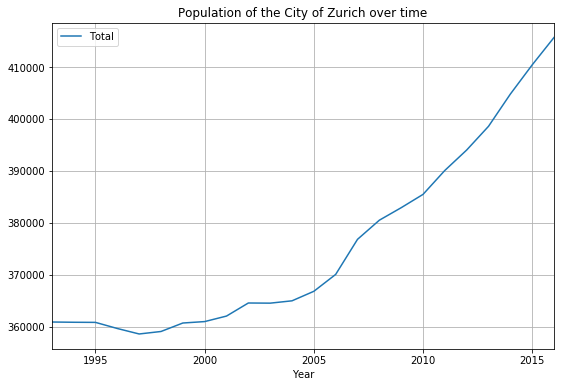

In [9]:
ZH_popul_Total = df_subset_total(ZH_popul, ['Year', 'district_name'], 'Total')
ZH_popul_Total.set_index('Year').to_csv('Data/ZH_popul_Total.csv', encoding='utf-8', index = True)
ZH_popul_Total.reset_index()
ZH_popul_gender = df_subset_total(ZH_popul, ['Year', 'district_name', 'gender'], 'Total')
ZH_popul_gender.set_index('Year').to_csv('Data/ZH_popul_gender.csv', encoding='utf-8', index = True)
ZH_popul_CH = df_subset_total(ZH_popul, ['Year', 'district_name', 'CH_nonCH'], 'Total')
ZH_popul_CH.set_index('Year').to_csv('Data/ZH_popul_CH.csv', encoding='utf-8', index = True)


ZH_total_popul.plot.line(x='Year', grid=True, figsize=(9,6), title='Population of the City of Zurich over time')

We can see that the population has grown, first at a rate of 1250 per year from 1998-2006 and then at a steady rate of around 4500 per year since 2006. That is equivalent to around 1.25% per year.

### Analysing changes in moves over time

#### Annual total number of moves and per 100 people of the population

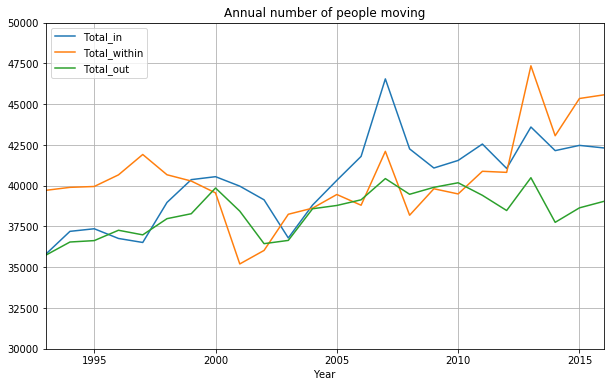

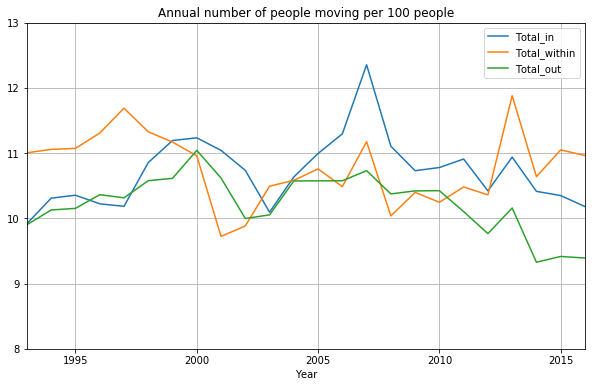

In [10]:
ZH_in_annual = df_subset_total(ZH_in_df, 'Year', 'Total').set_index('Year')
ZH_in_annual.columns = ['Total_in']
ZH_within_annual = df_subset_total(ZH_within_df, 'Year', 'Total').set_index('Year')
ZH_within_annual.columns = ['Total_within']
ZH_out_annual = df_subset_total(ZH_out_df, 'Year', 'Total').set_index('Year')
ZH_out_annual.columns = ['Total_out']
ZH_moves_totals = pd.concat([ZH_in_annual, ZH_within_annual, ZH_out_annual], axis=1 )
ZH_moves_totals.plot.line(title='Annual number of people moving', grid=True, ylim = (30000,50000),figsize=(10,6) )

ZH_total_popul_yearindex=ZH_total_popul.set_index('Year')
# Representing moves against population per 100
ZH_moves_per_100 = ZH_moves_totals[['Total_in', 'Total_within', 'Total_out']].div(ZH_total_popul_yearindex['Total'], axis=0)*100

ZH_moves_per_100.plot.line(title='Annual number of people moving per 100 people', grid=True, ylim = (8,13),figsize=(10,6) )

**Observations:** 

1) All three movements are roughly of equal scale. In particular, there are as many people moving between districts as either move in from outside or move out to elsewhere.

2) The long term trend for the total number in all three groups is up. However when we adjust against the current population we see that per 100 ZH_in and ZH_out slightly decrease in the last decade (even ignoring 2007 spike). Only per 100 ZH_within has gone up in the last 5 years.

The long term views for any of the movements show no clear change compared to the annual fluctuations. ZH_within has just recovered the dip from 11% to 10% has just been recovered.

3) According to these figures, from 2005 onwards we have an on-going net gain (ZH_in - ZH_out) of 2000-5000 people per year from 2005 onwards. In the interval [2006-2016] the overall population increase on average by 4000 people. However, our current analysis ignores births and deaths for Zurich!

4) If we have a year-to-year change of more than 2500, say, then we consider this a sharp drop or sharp rise. If a sharp rise is followed by a sharp drop, and the corrected net change would not be classified as sharp, then we consider it a spike or dip.

Following these notions we observe: 

ZH_in: We have a dip in 2003 and spike in 2007. 2013 appears to be due to general fluctuations.

ZH_within: We have a sharp drop in for 2001 (wider dip 2001 and 2002) and spikes in 2007 and 2013. 

ZH_out: We have a wider dip in 2002 and 2003. 2013 appears to be due to general fluctuations.


**Questions and tasks:** 

Do the dips around 2002 and the spikes in 2007 and 2013 result from certain subsets of the population? That is to say: Are there subsets for which these charcateristics appear and others for which they are not noticable? 

Was the change for ZH_in caused by Swiss people or by an increase for a specific group of foreigners?

Are these general changes reflected across all districts, too? Or do they vary by districts?

**Task:** 

Data should show which districts grew in number and in relative terms (expect inner city to have few extra buildings). Allow us to compare movement figures against base population.

### An observation

The shape of the graph for people moving to Zurich matches the shape of the Swiss Performance index (SPI) between 1995 and 2010 --- picture below. This suggest that the performance of the economy as tracked by the SPI influences the attraction for people to move to Zurich.

The spikes and dips observed in the othe two moving groups coincide with those of the SPI. However the overall profile matches less. 


### The percentage of women (the gender gap)

We analyse the ratio between men and women. First we look at the overall population and then we look at the ratios for people moving to, within and away from Zurich.

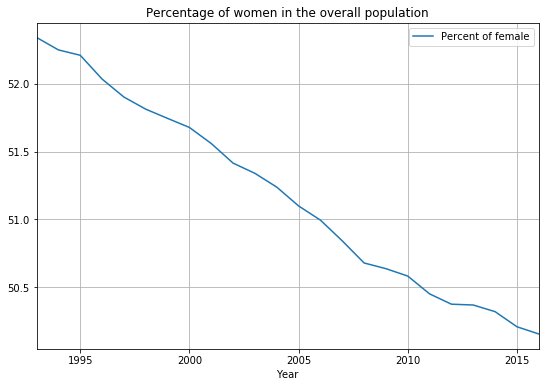

In [11]:
ZH_gender_percent = df_subset_percent(ZH_popul, ['Year'], 'gender', 'Total')
ZH_Female_percent =ZH_gender_percent[ZH_gender_percent['gender']=="F"]
ZH_Female_percent.rename(columns={'Percent of gender': 'Percent of female'}, inplace=True)

ZH_Female_percent.plot.line(x='Year', y='Percent of female', grid=True, figsize=(9,6), title='Percentage of women in the overall population')

We can see that the percentage of women has steadily declined from 52.5% to almost 50%. Hence in the overall population of Zurich the gender gap was in favour of women and has now closed.

#### Annual number of moves by gender

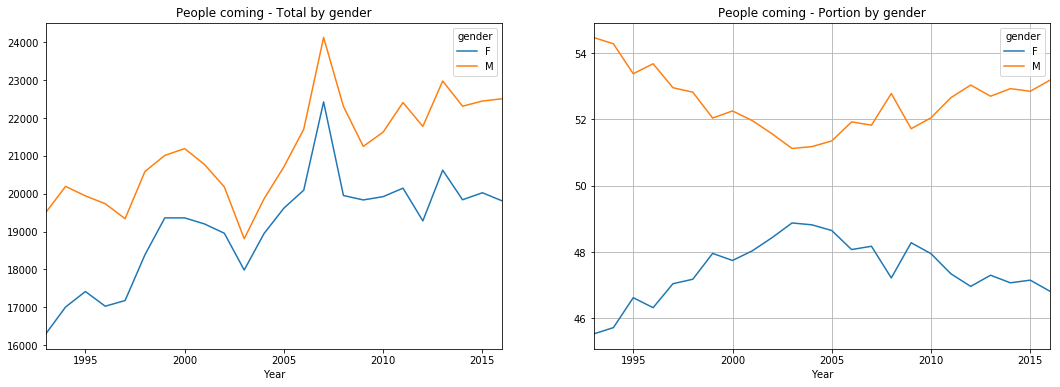

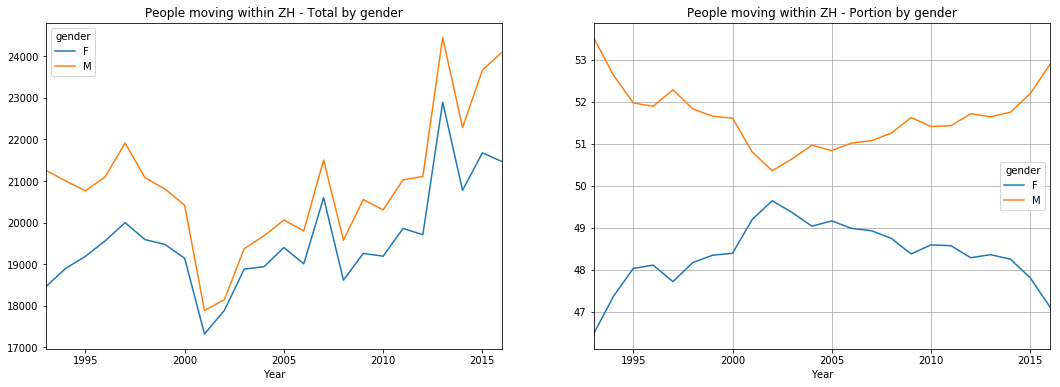

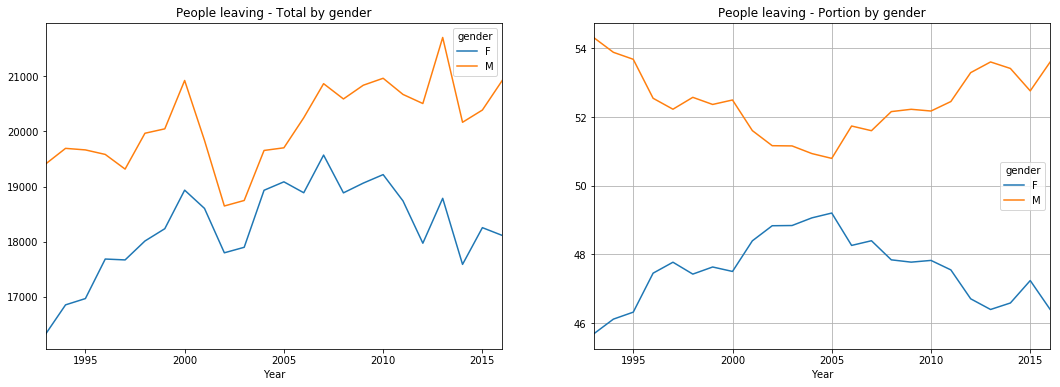

In [12]:
df_in = df_subset_total(ZH_in_df, ['Year', 'gender'], 'Total')
ZH_in_annual_by_gender_percent = df_subset_percent(df_in, 'Year', 'gender', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_in.pivot(values='Total', index='Year',columns='gender')
table1.plot.line(ax=axes[0], title='People coming - Total by gender', stacked=False)

table2 = ZH_in_annual_by_gender_percent.pivot(values='Percent of gender', index='Year',columns='gender')
table2.plot.line(ax=axes[1], title='People coming - Portion by gender', grid=True)


df_within = df_subset_total(ZH_within_df, ['Year', 'gender'], 'Total')
ZH_within_annual_by_gender_percent = df_subset_percent(df_within, 'Year', 'gender', 'Total')


fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_within.pivot(values='Total', index='Year',columns='gender')
table1.plot.line(ax=axes[0], title='People moving within ZH - Total by gender', stacked=False)

table2 = ZH_within_annual_by_gender_percent.pivot(values='Percent of gender', index='Year',columns='gender')
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by gender', grid=True)


df_out = df_subset_total(ZH_out_df, ['Year', 'gender'], 'Total')
ZH_out_annual_by_gender_percent = df_subset_percent(df_out, 'Year', 'gender', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_out.pivot(values='Total', index='Year',columns='gender')
table1.plot.line(ax=axes[0], title='People leaving - Total by gender', stacked=False)

table2 = ZH_out_annual_by_gender_percent.pivot(values='Percent of gender', index='Year',columns='gender')
table2.plot.line(ax=axes[1], title='People leaving - Portion by gender', grid=True)


**Observations:** 

The majority of women in the overall population is not reflected at all in the data for people moving. All three scenarios show a clear gender gap favouring men. This is no surprise for people moving to Zurich, as their profile should not be determined by the number of women, but instead by factors outside Zurich. However, we would expect that the number of women living in Zurich has an effect on how many move within and away form Zurich over time. This does not appear to be the case as the profiles are similar in all 3 scenarios.

**Conclusion:** 

We can see that women are far less likely to move than men. Men are more 'nomadic', while women stay for longer in one place.

**Observations of the gender profiles for the moving groups:** 

The **absolute numbers** per gender reflect those of the overall numbers of people moving.

ZH_in: We have a dip in 2003 and spike in 2007. 2013 appears to be due to general fluctuations.

ZH_within: We have a sharp drop in for 2001 (wider dip 2001 and 2002) and spikes in 2007 and 2013. 

ZH_out: We have a wider dip in 2002 and 2003. 2013 appears to be due to general fluctuations.

We observe that in all three settings the **gender gap** narrows by 6 percentage points (from 7-8pp to 1-2pp) 

Moreover in each case the dips around 2001-2003 happen a year befoer on at the same time as the narrowest gender gap and they mark a turning point after which the gap contniuoulsy widens again in all settings.

Note that in contrast the spikes of 2007 and 2013 are not reflected in the gender profile, i.e. their origin was equally spread amongst both genders. 


**Questions and tasks:** 

1) Why do we observe a dip in 2001-2003 and why does gender gap narrowing reverse thereafter?

2) The scale and trend of the gender gap is similar across all 3 settings. The question arises whether it differs by nationality? Conjecture: Immigrants from particular regions are predominantly single men. Once in ZH, they create a top up to the single amle group of the general population. Can we support this conjecture or is the gender gap apparent for Swiss people and other regions (Western Europe) as well  

3) For married couples we expect a 50/50 share of the female/male portions. Subtracting these should widen the overall gender gap. How much?

#### Annual number of moves by age

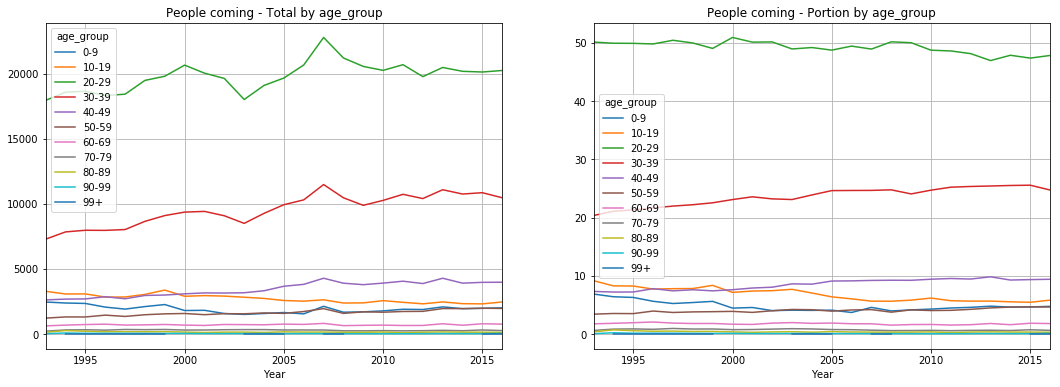

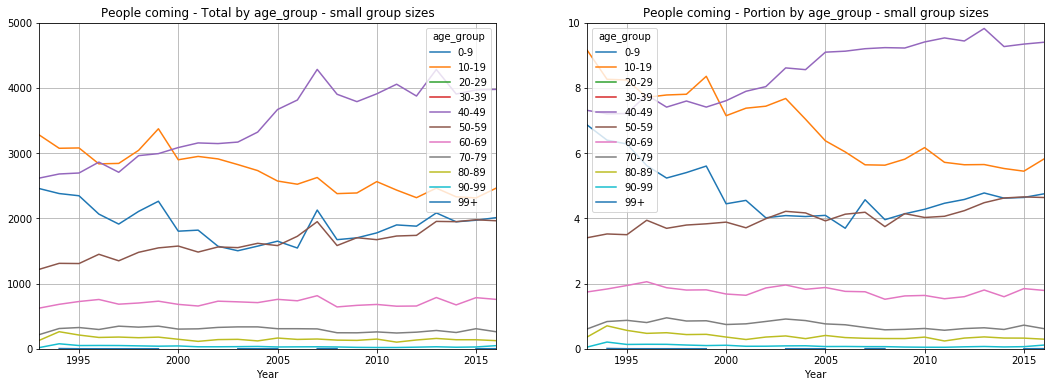

In [13]:
# In

df_in = df_subset_total(ZH_in_df, ['Year', 'age_group'], 'Total')
ZH_in_annual_by_age_group_percent = df_subset_percent(df_in, 'Year', 'age_group', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_in.pivot(values='Total', index='Year',columns='age_group')
table1.plot.line(ax=axes[0], title='People coming - Total by age_group', stacked=False, grid=True )

table2 = ZH_in_annual_by_age_group_percent.pivot(values='Percent of age_group', index='Year',columns='age_group')
table2.plot.line(ax=axes[1], title='People coming - Portion by age_group', grid=True )

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1.plot.line(ax=axes[0], title='People coming - Total by age_group - small group sizes', grid=True, ylim=(0,5000) )
table2.plot.line(ax=axes[1], title='People coming - Portion by age_group - small group sizes', grid=True , ylim=(0,10) )

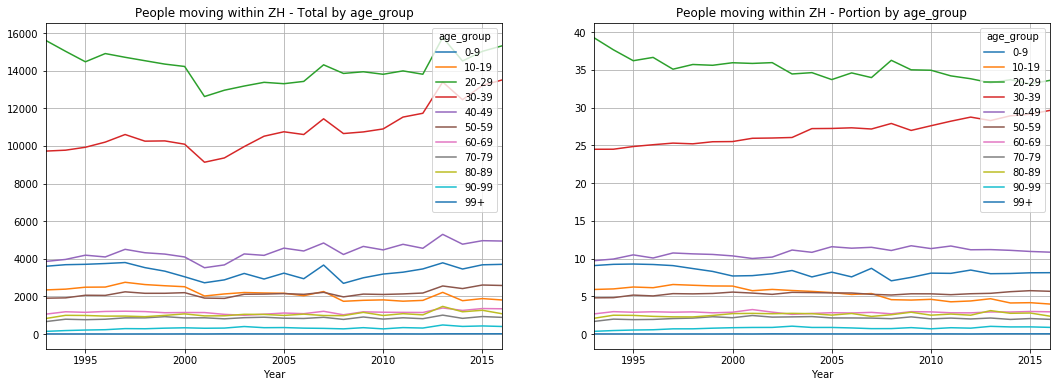

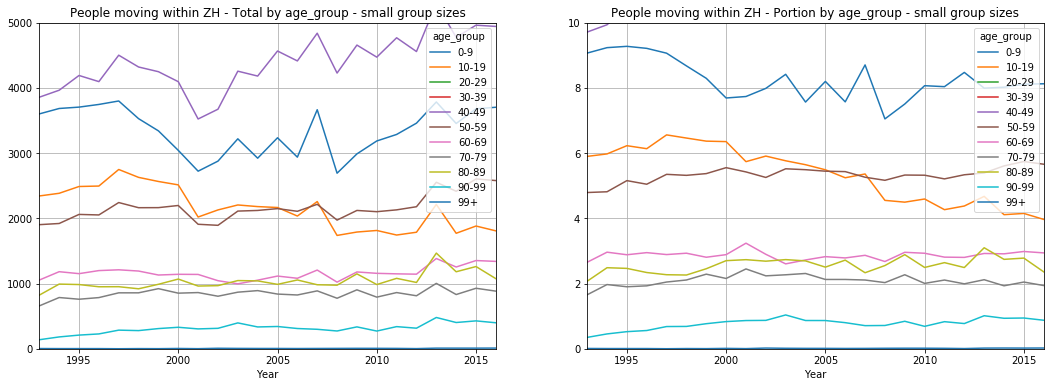

In [14]:
#Within

df_within = df_subset_total(ZH_within_df, ['Year', 'age_group'], 'Total')
ZH_within_annual_by_age_group_percent = df_subset_percent(df_within, 'Year', 'age_group', 'Total')


fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_within.pivot(values='Total', index='Year',columns='age_group')
table1.plot.line(ax=axes[0], title='People moving within ZH - Total by age_group', stacked=False, grid=True)

table2 = ZH_within_annual_by_age_group_percent.pivot(values='Percent of age_group', index='Year',columns='age_group')
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by age_group', grid=True)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1.plot.line(ax=axes[0], title='People moving within ZH - Total by age_group - small group sizes', grid=True, ylim=(0,5000) )
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by age_group - small group sizes', grid=True , ylim=(0,10) )

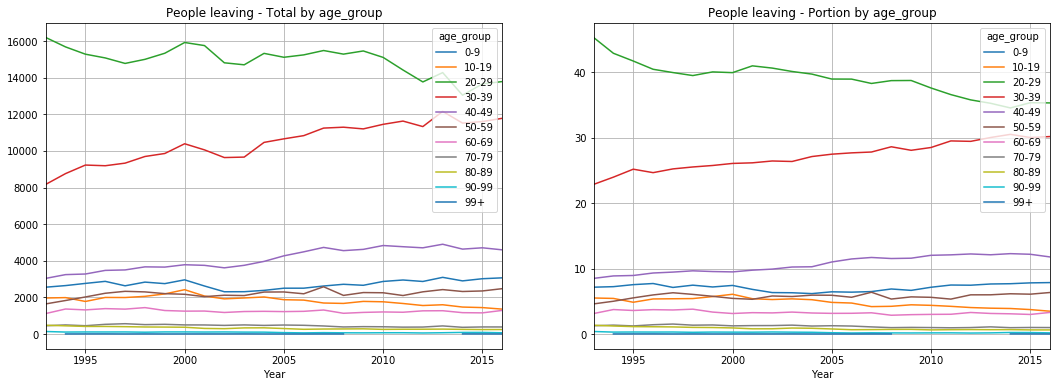

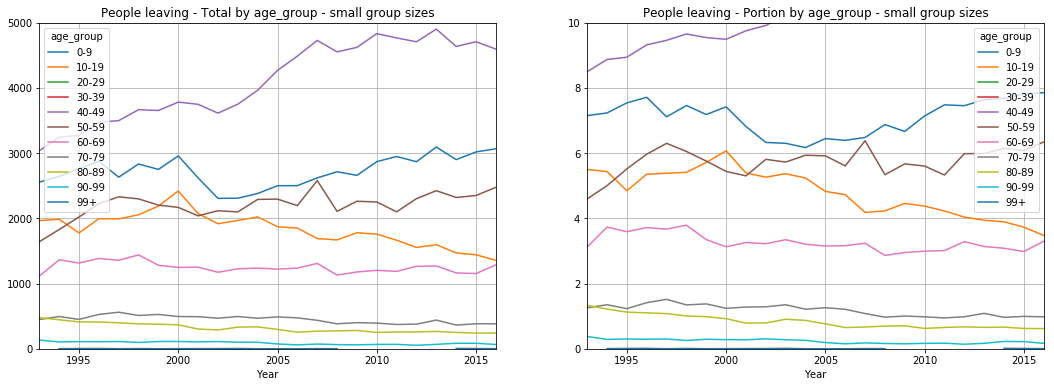

In [15]:
# Out

df_out = df_subset_total(ZH_out_df, ['Year', 'age_group'], 'Total')
ZH_out_annual_by_age_group_percent = df_subset_percent(df_out, 'Year', 'age_group', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_out.pivot(values='Total', index='Year',columns='age_group')
table1.plot.line(ax=axes[0], title='People leaving - Total by age_group', stacked=False, grid=True)

table2 = ZH_out_annual_by_age_group_percent.pivot(values='Percent of age_group', index='Year',columns='age_group')
table2.plot.line(ax=axes[1], title='People leaving - Portion by age_group', grid=True)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1.plot.line(ax=axes[0], title='People leaving - Total by age_group - small group sizes', grid=True, ylim=(0,5000) )
table2.plot.line(ax=axes[1], title='People leaving - Portion by age_group - small group sizes', grid=True , ylim=(0,10) )

In [16]:
# Creating a data frame that focuses on young professionals '20-29' and '30-39'
young_prof = df_select_values(ZH_within_annual_by_age_group_percent, 'age_group', ['20-29','30-39'])

**Observations:** 

1) In all 3 cases the strongest groups are '20-29', then '30-39' and '40-49'. 

2) The total number of '20-29' is (up - in, steady - within, down - out).
 
The portion of '20-29' decreases over time by (-2.3% in, -5.7% within, -10% out). We could say that this age group becomes more 'sesshaft' - in relative terms.

3) There is a significant increase of the total number of '30-39' moving in general. We could conclude that people in this group decide/are  for forced to move more often. (Need comparison against overall population.)

The portion of '30-39' increases over time by (4.3% in, 5.1% within, 7.3% out). We could say that this age group becomes more 'mobile' - in relative terms.

4) Comparing children '0-9' and '10-19'. The groups are typically ranked 4 and 5.
There are more '10-19' moving to ZH, whereas '0-9' are more likely to move within ZH or leave ZH.

The total number of ‘10-19’ decreases in all 3 scenarios.

ZH_in: 1999 sees a brief spike for both age groups (not reflected in any other age group!)), and for '0-9' the spike of 2007 follows the general trend, but for ‘10-19’ it is absent. 

ZH_within: The drop of 2001 and the spikes of 2007 and 2013 are matched by both sets. 

ZH_out: 2013 on the other hand appears not noticeable for ZH_out in either group.

5) The groups 60+ , with pensioners or those close to retirement, generally do not move as much. This is particularly noticeable ZH_in where their portion is generally smaller than in the other two cases. 

’60-69’ make up around 2%,3%,4% of the three groups (in, within, out). For ZH_in  and ZH_out they set themselves apart from the older groups, whereas all the age groups 60+ for ZH_within are on comparable sales.

The profiles for the groups 60+, does not show the dips around 2001-2003, nor the spikes of 2007 or 2013. This suggest that events related to those dips and spikes did not affect pensioners. In other words those events appear to be related to the economy, affecting household incomes (but not pensions). 

#### Questions and Tasks

Quantify and make a visual comparison between portions of individual subgroups for in, within, out and total population.

1) Can we say that there was a particular change overtime?

2) For which group is the portion of against the overall population changing most significantly?

3) Plot percentage change against 1993 value for each group. Expect [20-29] steady in all 3, [30-39] up by 30% in all 3. What about the other ones? Trend appears to depend on age_group and in/within/out.

4) Are these trends similar when we focus on single/married/divorced people? (Later are a mix of the first two as they are more likely to have kids and in that case be constraint by ex-partners wanting access.)


#### Annual number of moves by marital status

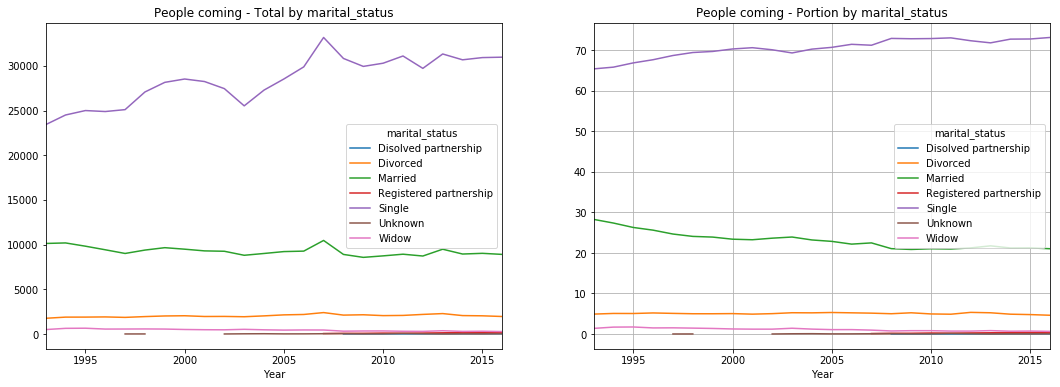

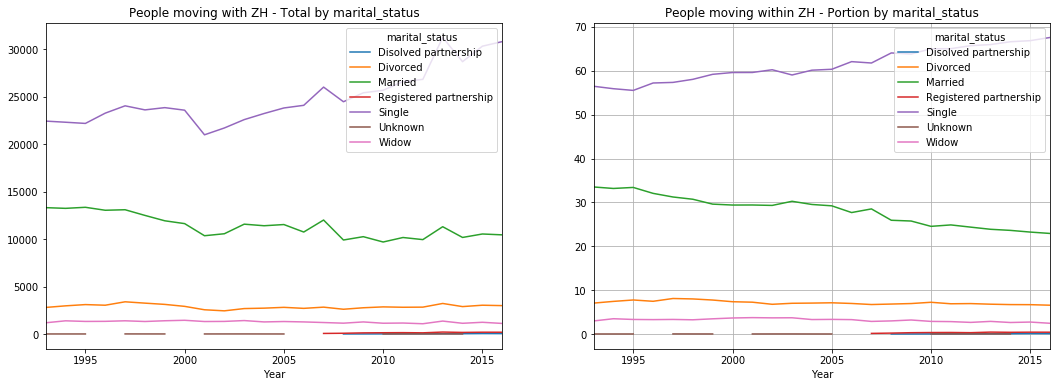

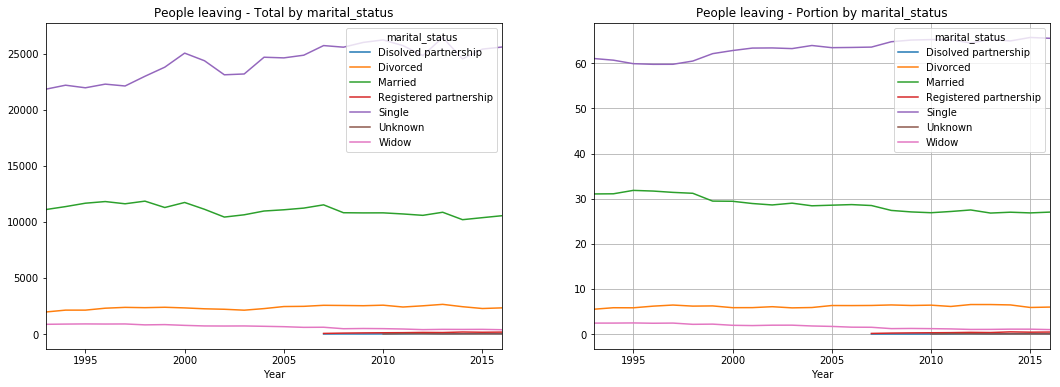

In [17]:
df_in = df_subset_total(ZH_in_df, ['Year', 'marital_status'], 'Total')
ZH_in_annual_by_marital_status_percent = df_subset_percent(df_in, 'Year', 'marital_status', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_in.pivot(values='Total', index='Year',columns='marital_status')
table1.plot.line(ax=axes[0], title='People coming - Total by marital_status', stacked=False)

table2 = ZH_in_annual_by_marital_status_percent.pivot(values='Percent of marital_status', index='Year',columns='marital_status')
table2.plot.line(ax=axes[1], title='People coming - Portion by marital_status', grid=True)


df_within = df_subset_total(ZH_within_df, ['Year', 'marital_status'], 'Total')
ZH_within_annual_by_marital_status_percent = df_subset_percent(df_within, 'Year', 'marital_status', 'Total')


fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_within.pivot(values='Total', index='Year',columns='marital_status')
table1.plot.line(ax=axes[0], title='People moving with ZH - Total by marital_status', stacked=False)

table2 = ZH_within_annual_by_marital_status_percent.pivot(values='Percent of marital_status', index='Year',columns='marital_status')
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by marital_status', grid=True)


df_out = df_subset_total(ZH_out_df, ['Year', 'marital_status'], 'Total')
ZH_out_annual_by_marital_status_percent = df_subset_percent(df_out, 'Year', 'marital_status', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_out.pivot(values='Total', index='Year',columns='marital_status')
table1.plot.line(ax=axes[0], title='People leaving - Total by marital_status', stacked=False)

table2 = ZH_out_annual_by_marital_status_percent.pivot(values='Percent of marital_status', index='Year',columns='marital_status')
table2.plot.line(ax=axes[1], title='People leaving - Portion by marital_status', grid=True)


**Observations:** 

Note single adult people are indivdual moves, while children count as single but are dependants. So the number of moves involving indviduals is lower.

Instead, children form part of a family that moves, i.e. track the move of 2 married people (or divorced). So for married people the numbers halve to get household moves.

**Questions and tasks:** 

If we are interested in the number of households moving (independent units) then we need to drop children and halve the number of married people.

Observe that partnerships did not get counted until Year XYZ.

Look for time series how the number of Single and Married people changes over time.

### District specific analysis

We aim to carry out the following analyses:

1) Contrast the development of the percentage of foreigners in each district over time by creating the individual bar plots.

2) Consider analogous analyses using percentages of the total district population in each case for 
a) gender, b) singles, c) married people, d) age groups like [0-19], [20-39] or pensioners 

3) Plot average annual age and s.d. per district (use the population frame with the exact ages)

4) Create a population profile by district for each year and compare the ZH_within pattern for each year with this profile, as differences (positive means attractive, negative means unattractive) 

5) Calculate the flow of people between districts. Display the netflow (positive and negative) 

In [18]:
# Define the Kreis according to the districts (https://de.wikipedia.org/wiki/Stadtteile_der_Stadt_Zürich)
# Group 3 Kreise into bigger sets of 7-9 districts
Kreis1 = ['Rathaus', 'Hochschulen', 'Lindenhof', 'City']
Kreis2 = ['Wollishofen', 'Leimbach', 'Enge']
Kreis3 = ['Alt-Wiedikon', 'Friesenberg', 'Sihlfeld']
Set1= Kreis1 + Kreis2 + Kreis3 

Kreis4 = ['Werd', 'Langstrasse', 'Hard']
Kreis5 = ['Gewerbeschule', 'Escher Wyss']
Kreis6 = ['Unterstrass', 'Oberstrass']
Set2= Kreis4 + Kreis5 + Kreis6 

Kreis7 = ['Fluntern', 'Hottingen', 'Hirslanden', 'Witikon']
Kreis8 = ['Seefeld', 'Mühlebach', 'Weinegg']
Kreis9 = ['Albisrieden', 'Altstetten']
Set3= Kreis7 + Kreis8 + Kreis9 

Kreis10 = ['Höngg', 'Wipkingen']
Kreis11 = ['Affoltern', 'Oerlikon', 'Seebach']
Kreis12 = ['Saatlen', 'Schwamendingen-Mitte', 'Hirzenbach']
Set4= Kreis10 + Kreis11 + Kreis12 


#### Total population by districts

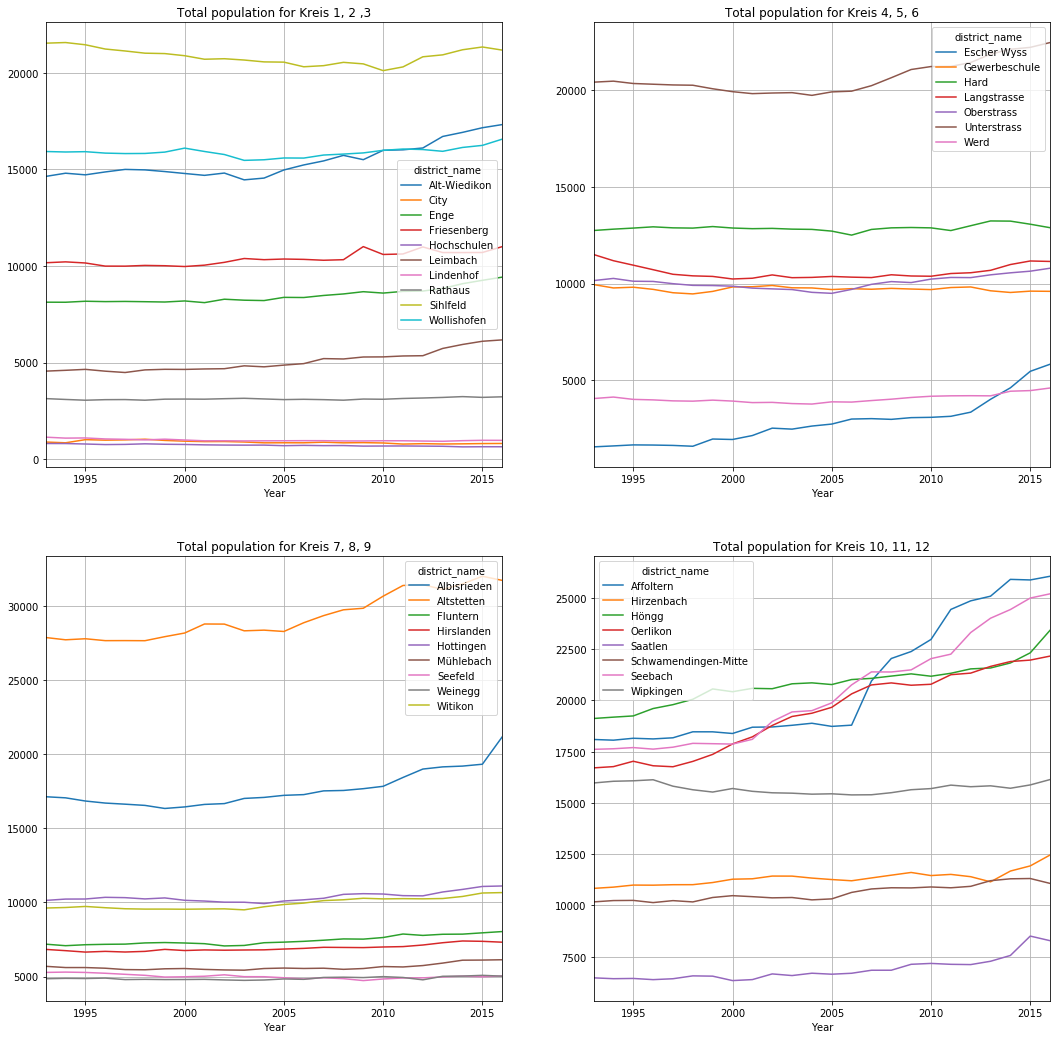

In [19]:
ZH_popul_Total_Set1 = df_select_values(ZH_popul_Total, 'district_name', Set1)
ZH_popul_Total_Set2 = df_select_values(ZH_popul_Total, 'district_name', Set2)
ZH_popul_Total_Set3 = df_select_values(ZH_popul_Total, 'district_name', Set3)
ZH_popul_Total_Set4 = df_select_values(ZH_popul_Total, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_popul_Total_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Total population for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_popul_Total_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Total population for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_popul_Total_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Total population for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_popul_Total_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Total population for Kreis 10, 11, 12', stacked=False, grid=True)



** Observation ** 

Overall we can spot different trends (with examples):

a) some stagnated: Rathaus, City, Hochschulen

b) some grew steadily at similar rates: Altstetten, Oerlikon (with different rates for 1997-2007 and 2007-2017), Hoengg

c) others were stagnating and then started to increase at a specific point in time: Affoltern from 2007, Seebach from 2000, Escher Wyss from 1998 and then even more from 2012.

d) and some decline slightly before recovering: Langstrasse, Wipkingen

Of course there may be various reasons for these trends. Down town has limited capacity of living space and little chnce to expand. Outer districts may gradually build up open (green) space or convert industrial areas (brown space) into residential areas. Affoltern seems to be an example where there was a sudden increase in people moving there. Given the prior stagnation this suggest a sudden availability of living space through new buildings.

However we can observe that Hard, Langstrasse, Werd and Gewerbeschule all stagnate and all lie in Kreis 4 und 5.

Similarly Saatlen, Schwamendingen-Mitte, Hirzenbach stagnate and all lie in Kries 12.

In the final two panels Altstetten, (Albisrieden,) Affoltern, Hoengg, Oerlikon and Seebach all show growths. These districts all lie along teh North-West periphery in Kreis 9, 10, 11.

The centre and the South (Kreis 2, 3, 8) are mostly static.

So there are some clear indicators of geolocation relting to growht here. (and this was to be expected)

** Questions **

How did the age and gender distribution change (or not) with time in districts following different trends?

Did the distribution of people moving to Affoltern in the years after 2007 show a characteristic profile?

#### The evolution of the percentage of foreigners per district over time

We calculate the percentage of amongst the population a) in ZH, b) in each district. This allows us to measure how international individual districts are.

We want to analyse these rates over time to see whether districts became more diverse or less. 

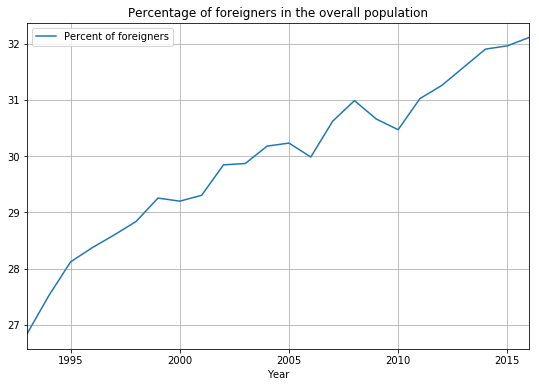

In [20]:
# Calculate the annual total number of foreigners in ZH and their portion of the ZH population

ZH_CHnonCH_percent = df_subset_percent(ZH_popul, ['Year'], 'CH_nonCH', 'Total')
ZH_Foreign_percent =ZH_CHnonCH_percent[ZH_CHnonCH_percent['CH_nonCH']=="Foreign"]


ZH_Foreign_percent.rename(columns={'Percent of CH_nonCH': 'Percent of foreigners'}, inplace=True)

ZH_Foreign_percent.plot.line(x='Year', y='Percent of foreigners', grid=True, figsize=(9,6), title='Percentage of foreigners in the overall population')

We can see that the overall population has clearer become more international. The rate of foreigners has steadily increased from27% to 32%, there is now 1 foreigner for every 2 swiss people.

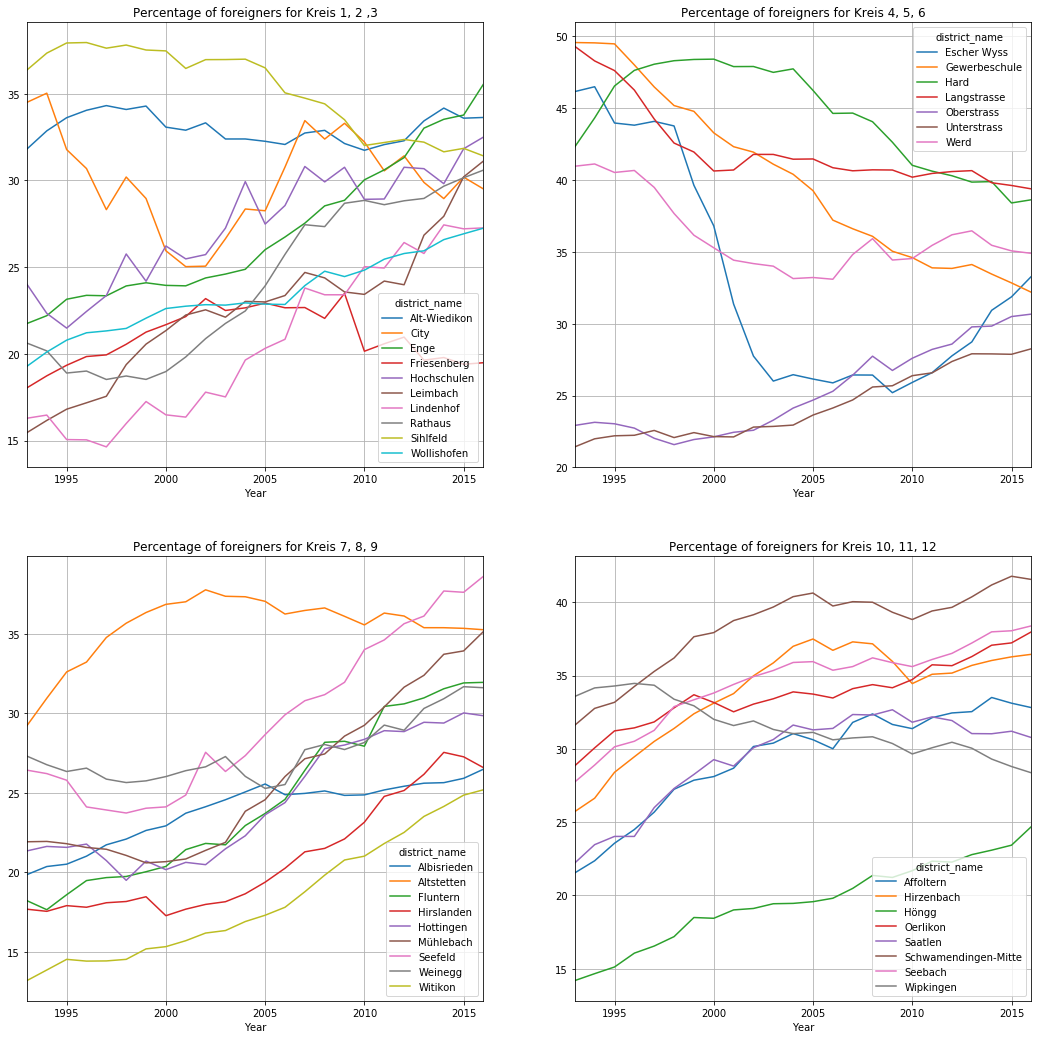

In [21]:
# Calculate the annual number of foreigners per dictrict and their portion of the district population
# Use df_subset_percent(df, retain_groups, percent_group, total_column)
ZH_district_CHnonCH_percent = df_subset_percent(ZH_popul, ['Year', 'district_name'], 'CH_nonCH', 'Total')
# Select foreigners (Foreign)
ZH_district_Foreign_percent =ZH_district_CHnonCH_percent[ZH_district_CHnonCH_percent['CH_nonCH']=="Foreign"]


# Plotting percentage of foreigners per district over time
ZH_district_Foreign_percent_Set1 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set1)
ZH_district_Foreign_percent_Set2 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set2)
ZH_district_Foreign_percent_Set3 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set3)
ZH_district_Foreign_percent_Set4 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_Foreign_percent_Set1.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of foreigners for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_Foreign_percent_Set2.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of foreigners for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_Foreign_percent_Set3.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of foreigners for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_Foreign_percent_Set4.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of foreigners for Kreis 10, 11, 12', stacked=False, grid=True)

**Observations**

We see a very clear trend of rising rates of foreigners in all of Kreis 7-12 (with the exception of Wipkingen).
Rates in 1993 were between 13% and 34% and have risen to 25% to 42%. However in Kreis 10-12 rates have mostly plateaued since 2005, whereas Kreis 7-9 continuously increased.

Kreis 1 and 2 have similarly increases (City has fluctuated), as has Kreis 6 (Oberstrass und Unterstrass).

In contrast in Kreis 3 (Friesenberg, Sihlfield, Alt-Wiedikon) 4 and 5 rates have stagnated or declined. Friesenberg has by far the lowest rate of foreigners in 2016 (< 20% - all others at least 25%). 

Escher Wyss is an exceptional case with the rate of foreigners collapsing from 44% to 26% in just 5 years (1998-2003). However, rates have recovered steadily since 2010 to 33%.

** Question**

It is surprising to see such clear distinctions according to Kreis boundaries, rather than districts within a Kreis acting distinctly. Do the Kreis collectively have the same politcal and adminstrative decision making bodies that homogenise planning and socio-economic decisions?

#### The evolution of the gender gap per district over time

We analysed the gender gaps earlier. The overall population had showed a decline from 52.5% to 50% over time. However the moves did not reflect that.

Now we look at individual districts.

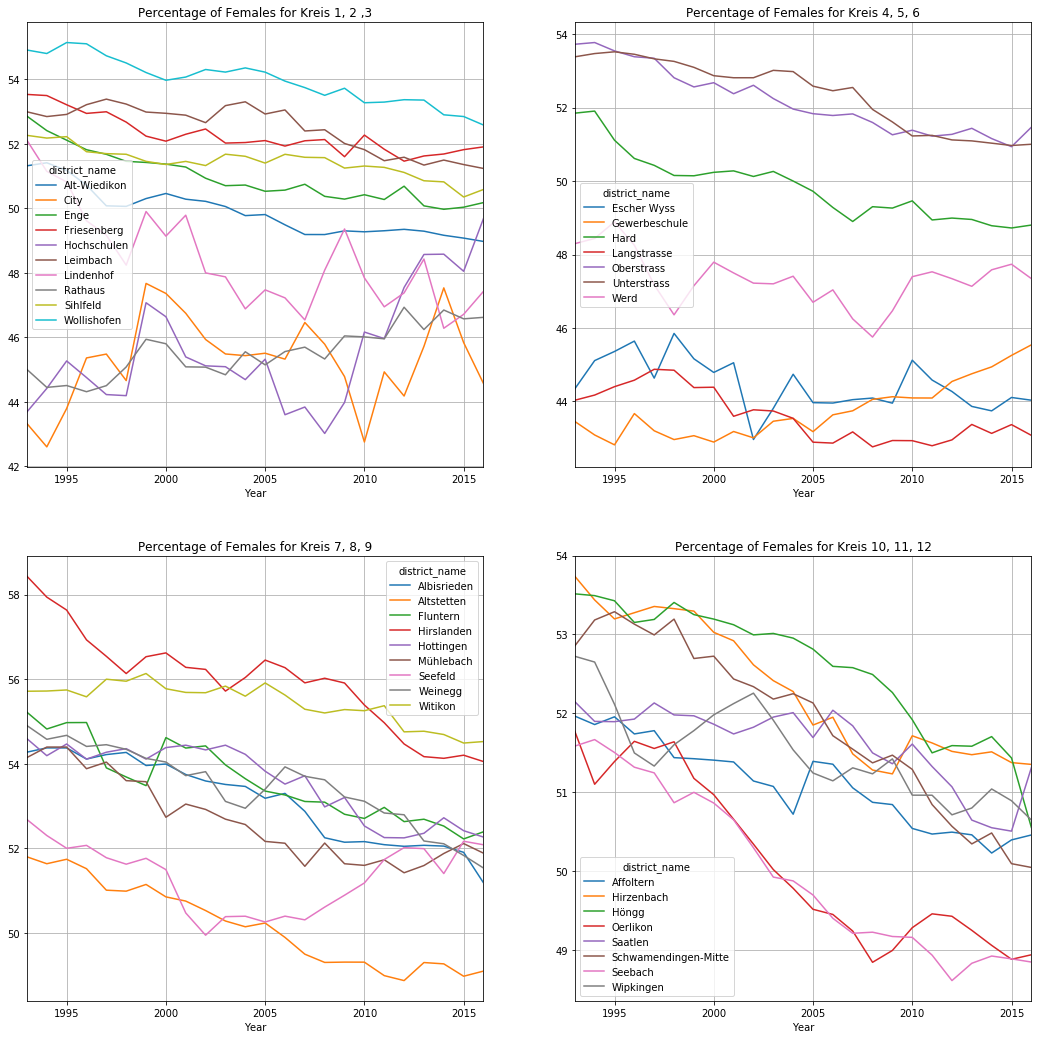

In [22]:
#df_subset_percent(df, retain_groups, percent_group, total_column)
ZH_district_gender_percent = df_subset_percent(ZH_popul, ['Year', 'district_name'], 'gender', 'Total')
# Select females
ZH_district_Female_percent =ZH_district_gender_percent[ZH_district_gender_percent['gender']=="F"]


# Plotting percentage of Femaleers per district over time
ZH_district_Female_percent_Set1 = df_select_values(ZH_district_Female_percent, 'district_name', Set1)
ZH_district_Female_percent_Set2 = df_select_values(ZH_district_Female_percent, 'district_name', Set2)
ZH_district_Female_percent_Set3 = df_select_values(ZH_district_Female_percent, 'district_name', Set3)
ZH_district_Female_percent_Set4 = df_select_values(ZH_district_Female_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_Female_percent_Set1.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of Females for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_Female_percent_Set2.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of Females for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_Female_percent_Set3.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of Females for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_Female_percent_Set4.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of Females for Kreis 10, 11, 12', stacked=False, grid=True)

**Observations**

In 1993 the rate of women was above 50% in most districts (51%-58%); and all of these districts the rate has slowly but steadily fallen to 49%-55%. The exceptions are the districts in Kreis 1, 4 and 5, where rates have always been below 50%, oscillating between 42% and 50% (Hard declines from 52% to 49%).

This is in contrast to the observations we made about the consistent gender gap among people arriving in ZH and moving within ZH which could in parts explain the gradual decline above. However even the people leaving ZH were predominantly women. 

** Question**

Since married couples split their part of the population in a 50-50 ratio, the above figures suggest that the ratios of female amongst singles should follow the above trends even more. Since women typically live longer than men and hence outlive them in most marriages, we hence suspect that the portion of female widows is higher than 50%.

#### The evolution of the age groups per district over time

**Description:**

We are interested in the age decomposition of ZH. We split the population into 5 groups and analyse 4 of them in more detail. The 4 groups have been chosen as they are on similar scales. They are: 

a) children [0-19], 

b) young professionals [20-29]

c) mid professionals [30-39]

d) seniors [60+]

(We are obmitting the older professionals [40-59] here.)

First we calculate and plot the portions of each group in the overall population of ZH. Then we repeat the analyis at district level.

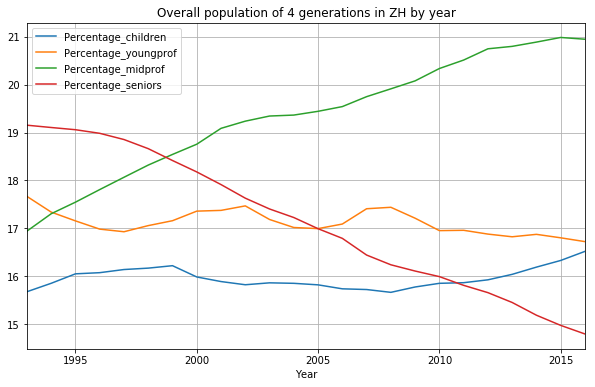

In [23]:
#df_subset_percent(df, retain_groups, percent_group, total_column)
# Annual numbers
ZH_age_percent = df_subset_percent(ZH_popul, ['Year'], 'age_group5', 'Total')
# Annual numbers by district
ZH_district_age_percent = df_subset_percent(ZH_popul, ['Year', 'district_name'], 'age_group5', 'Total')


# Finding the annual percentages for children, young professionals and seniors in the overall population

#df_select_values(df, selected_column, value_list):
ZH_children_percent =df_select_values(ZH_age_percent, "age_group5", ["0-4", "5-9","10-14","15-19"])
ZH_children_percent =df_subset_total(ZH_children_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_children_percent.rename(columns={'Total': 'Percentage_children'}, inplace=True)

# Originally had:
# ZH_youngprof_percent =df_select_values(ZH_age_percent, "age_group5", ["20-24", "25-29", "30-34", "35-39"])
# Then decided to split into yprof "20-29" and midprof "30-39"
ZH_youngprof_percent =df_select_values(ZH_age_percent, "age_group5", ["20-24", "25-29"])
ZH_youngprof_percent =df_subset_total(ZH_youngprof_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_youngprof_percent.rename(columns={'Total': 'Percentage_youngprof'}, inplace=True)


ZH_midprof_percent =df_select_values(ZH_age_percent, "age_group5", ["30-34", "35-39"])
ZH_midprof_percent =df_subset_total(ZH_midprof_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_midprof_percent.rename(columns={'Total': 'Percentage_midprof'}, inplace=True)


ZH_seniors_percent =df_select_values(ZH_age_percent, "age_group5", 
                                                ["65-69","70-74","75-79","80-84","85-89","90-94","95-99","99+"])
ZH_seniors_percent =df_subset_total(ZH_seniors_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_seniors_percent.rename(columns={'Total': 'Percentage_seniors'}, inplace=True)

# Join the three dataframes and plot them in one graph
ZH_generations = pd.concat([ZH_children_percent, ZH_youngprof_percent, ZH_midprof_percent, ZH_seniors_percent], axis=1 )
ZH_generations.plot.line(title='Overall population of 4 generations in ZH by year', grid=True,figsize=(10,6) )

In [24]:
# Finding the annual percentages for children, young professionals and seniors in the overall population

#df_select_values(df, selected_column, value_list):
ZH_district_children_percent =df_select_values(ZH_district_age_percent, "age_group5", ["0-4", "5-9","10-14","15-19"])
ZH_district_children_percent =df_subset_total(ZH_district_children_percent, ["Year", "district_name"], "Percent of age_group5")

# Orignally [20-39] then split
# ZH_district_youngprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["20-24", "25-29","30-34","35-39"])

ZH_district_youngprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["20-24", "25-29"])
ZH_district_youngprof_percent =df_subset_total(ZH_district_youngprof_percent, ["Year", "district_name"], "Percent of age_group5")

#ZH_district_midprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["30-34","35-39"])
ZH_district_midprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["30-34","35-39"])
ZH_district_midprof_percent =df_subset_total(ZH_district_midprof_percent, ["Year", "district_name"], "Percent of age_group5")

ZH_district_seniors_percent =df_select_values(ZH_district_age_percent, "age_group5", 
                                                ["65-69","70-74","75-79","80-84","85-89","90-94","95-99","99+"])
ZH_district_seniors_percent =df_subset_total(ZH_district_seniors_percent, ["Year", "district_name"], "Percent of age_group5")


#### The evolution of the percentage of children per district over time

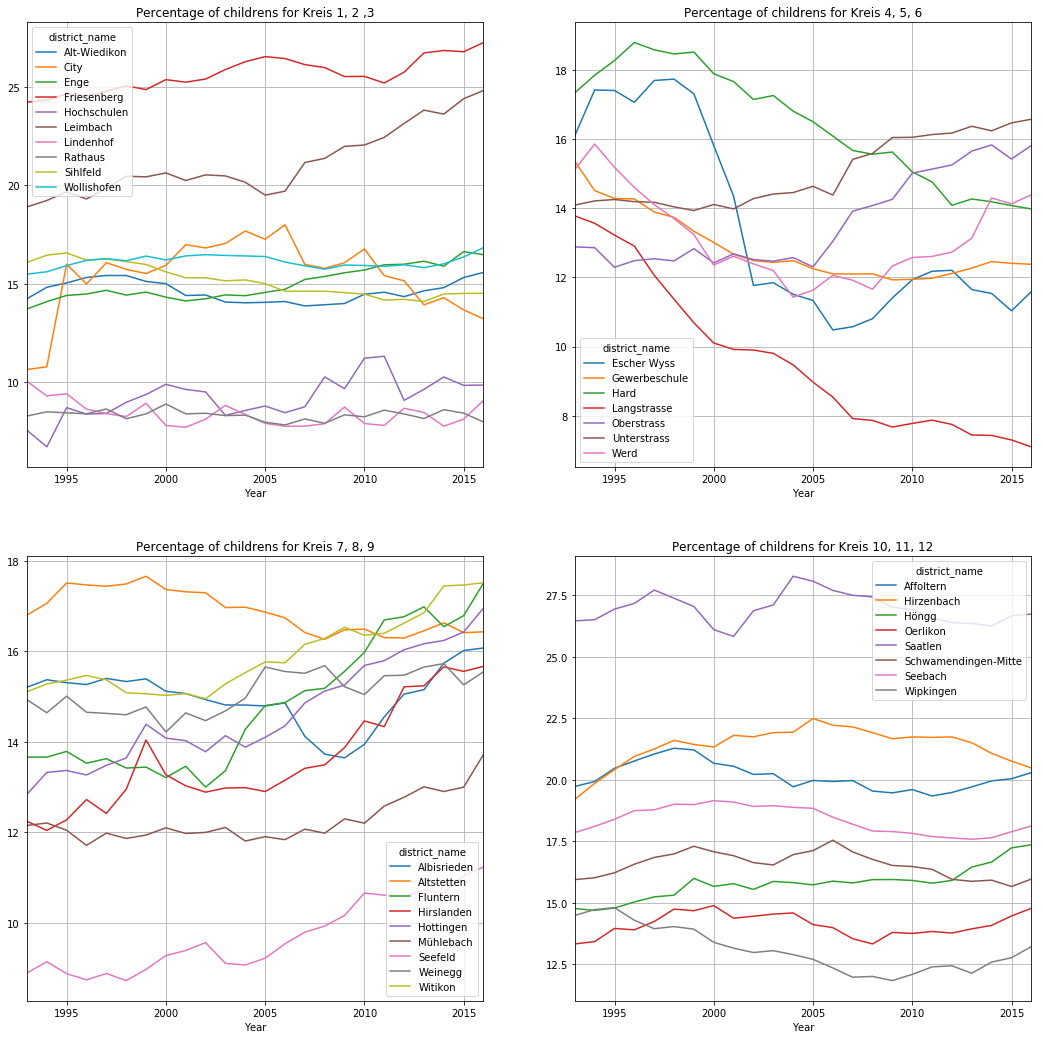

In [25]:
# Plotting percentage of children per district over time
ZH_district_children_percent_Set1 = df_select_values(ZH_district_children_percent, 'district_name', Set1)
ZH_district_children_percent_Set2 = df_select_values(ZH_district_children_percent, 'district_name', Set2)
ZH_district_children_percent_Set3 = df_select_values(ZH_district_children_percent, 'district_name', Set3)
ZH_district_children_percent_Set4 = df_select_values(ZH_district_children_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_children_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of childrens for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_children_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of childrens for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_children_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of childrens for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_children_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of childrens for Kreis 10, 11, 12', stacked=False, grid=True)

#### The evolution of the percentage of young professionals per district over time

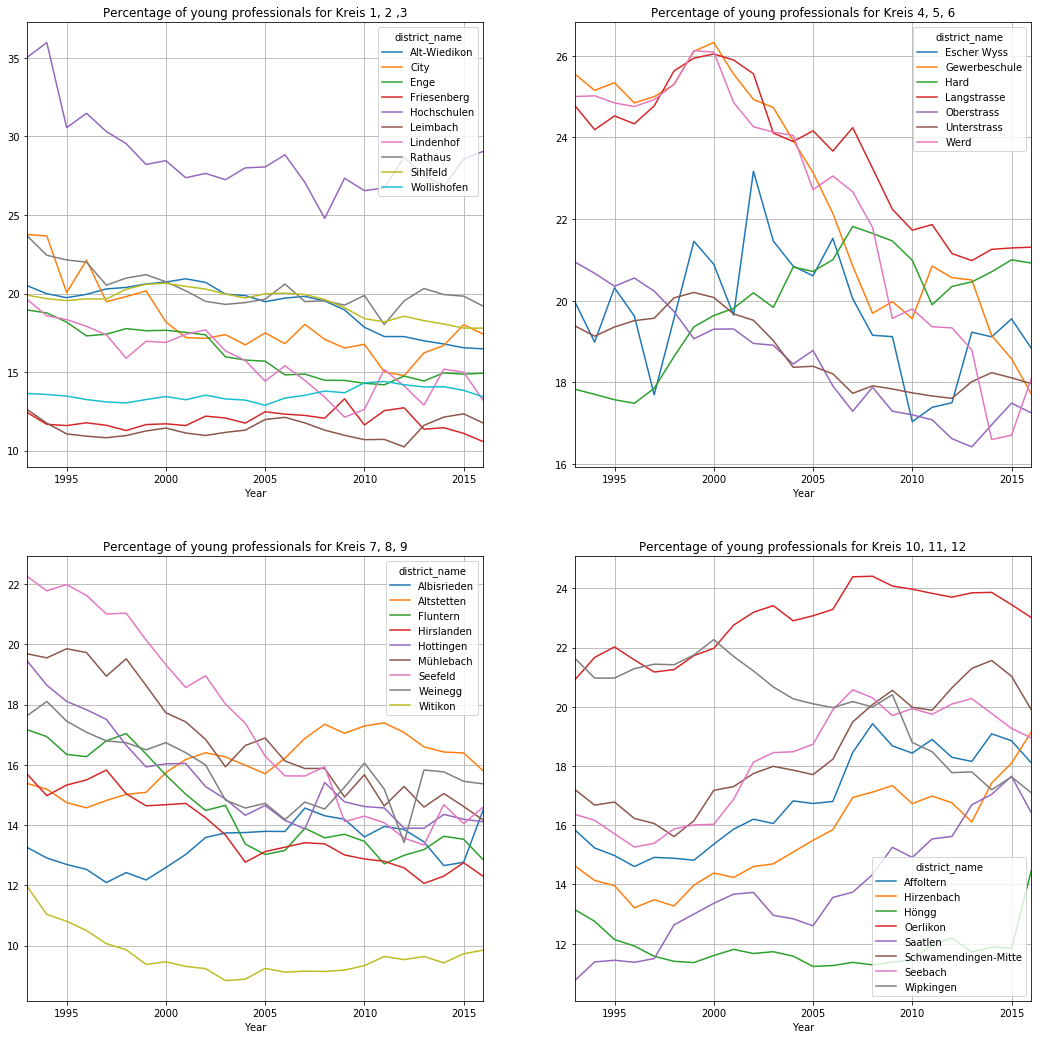

In [26]:
# Plotting percentage of young professionals per district over time
ZH_district_youngprof_percent_Set1 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set1)
ZH_district_youngprof_percent_Set2 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set2)
ZH_district_youngprof_percent_Set3 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set3)
ZH_district_youngprof_percent_Set4 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_youngprof_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of young professionals for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_youngprof_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of young professionals for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_youngprof_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of young professionals for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_youngprof_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of young professionals for Kreis 10, 11, 12', stacked=False, grid=True)

#### The evolution of the percentage of mid professionals per district over time

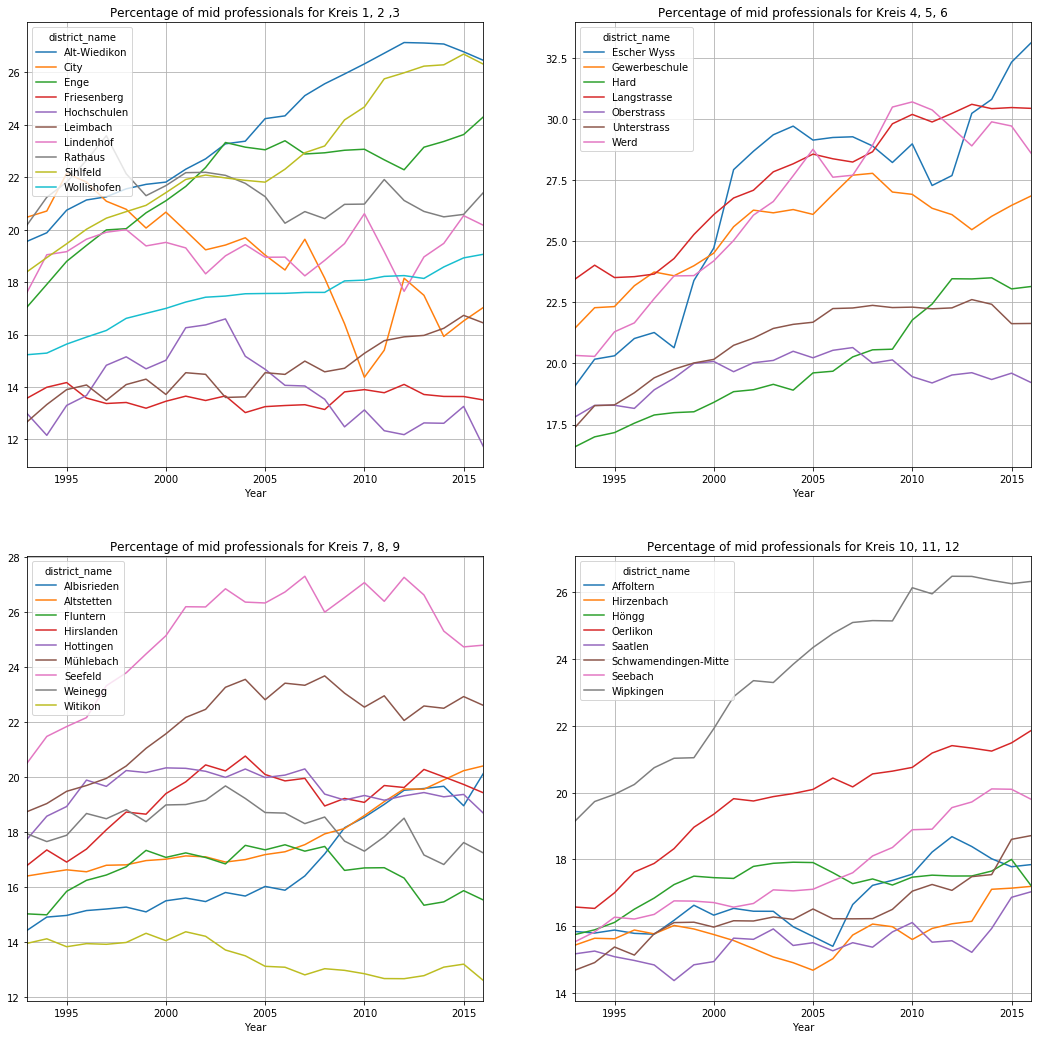

In [27]:
# Plotting percentage of mid professionals per district over time
ZH_district_midprof_percent_Set1 = df_select_values(ZH_district_midprof_percent, 'district_name', Set1)
ZH_district_midprof_percent_Set2 = df_select_values(ZH_district_midprof_percent, 'district_name', Set2)
ZH_district_midprof_percent_Set3 = df_select_values(ZH_district_midprof_percent, 'district_name', Set3)
ZH_district_midprof_percent_Set4 = df_select_values(ZH_district_midprof_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_midprof_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of mid professionals for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_midprof_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of mid professionals for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_midprof_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of mid professionals for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_midprof_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of mid professionals for Kreis 10, 11, 12', stacked=False, grid=True)

#### The evolution of the percentage of seniors per district over time

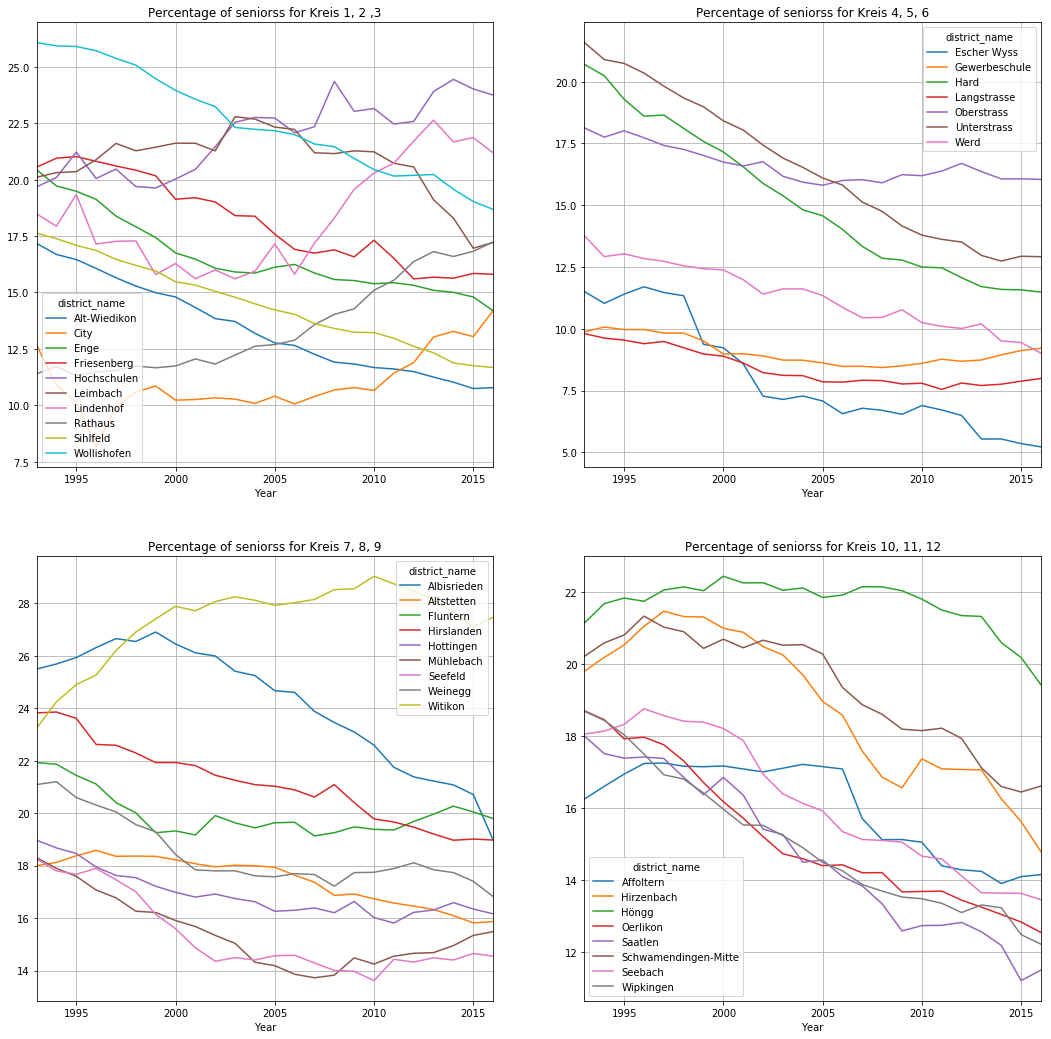

In [28]:
# Plotting percentage of seniors per district over time
ZH_district_seniors_percent_Set1 = df_select_values(ZH_district_seniors_percent, 'district_name', Set1)
ZH_district_seniors_percent_Set2 = df_select_values(ZH_district_seniors_percent, 'district_name', Set2)
ZH_district_seniors_percent_Set3 = df_select_values(ZH_district_seniors_percent, 'district_name', Set3)
ZH_district_seniors_percent_Set4 = df_select_values(ZH_district_seniors_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_seniors_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of seniorss for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_seniors_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of seniorss for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_seniors_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of seniorss for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_seniors_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of seniorss for Kreis 10, 11, 12', stacked=False, grid=True)

**Observations**

 We see that the percentages of children and young professionals in the overall population are stable over the years. The age group 30-39 increases from 17% to 21% which means their actual numbers will have risen by over 20%. In contrast the portion of over 60 and over has declined. As the city grows their portion steadily dropped from 19% to 15%.
 
 Overall the city has gotten 'younger in the middle ages', as the shift is driven by the number of people in their '30-39' and not as usually expected by the lower age groups.

For children, there is no general trend apart from some isolated districts that had increases. Escher Wyss had a sharp decline in the early 2000, which suggest that the district became unattractive for families with children who left the district. For Langstrasse teh decline was more even over the full 23 years.

Young professionals (20-29) have significantly turned away from most of Kreis 4,5 and 6. Similar observations hold for some districts in Kreis 7-9. Instead  they have moved to districts 10-12.



# Maps

In this section we plot a map over the moving in ratios. In addition to the map we also implemented widgets which allows the user to change certain parameters, in this case year and nationality.

In order to use the widgets the notebook most be opened in Jupyter.

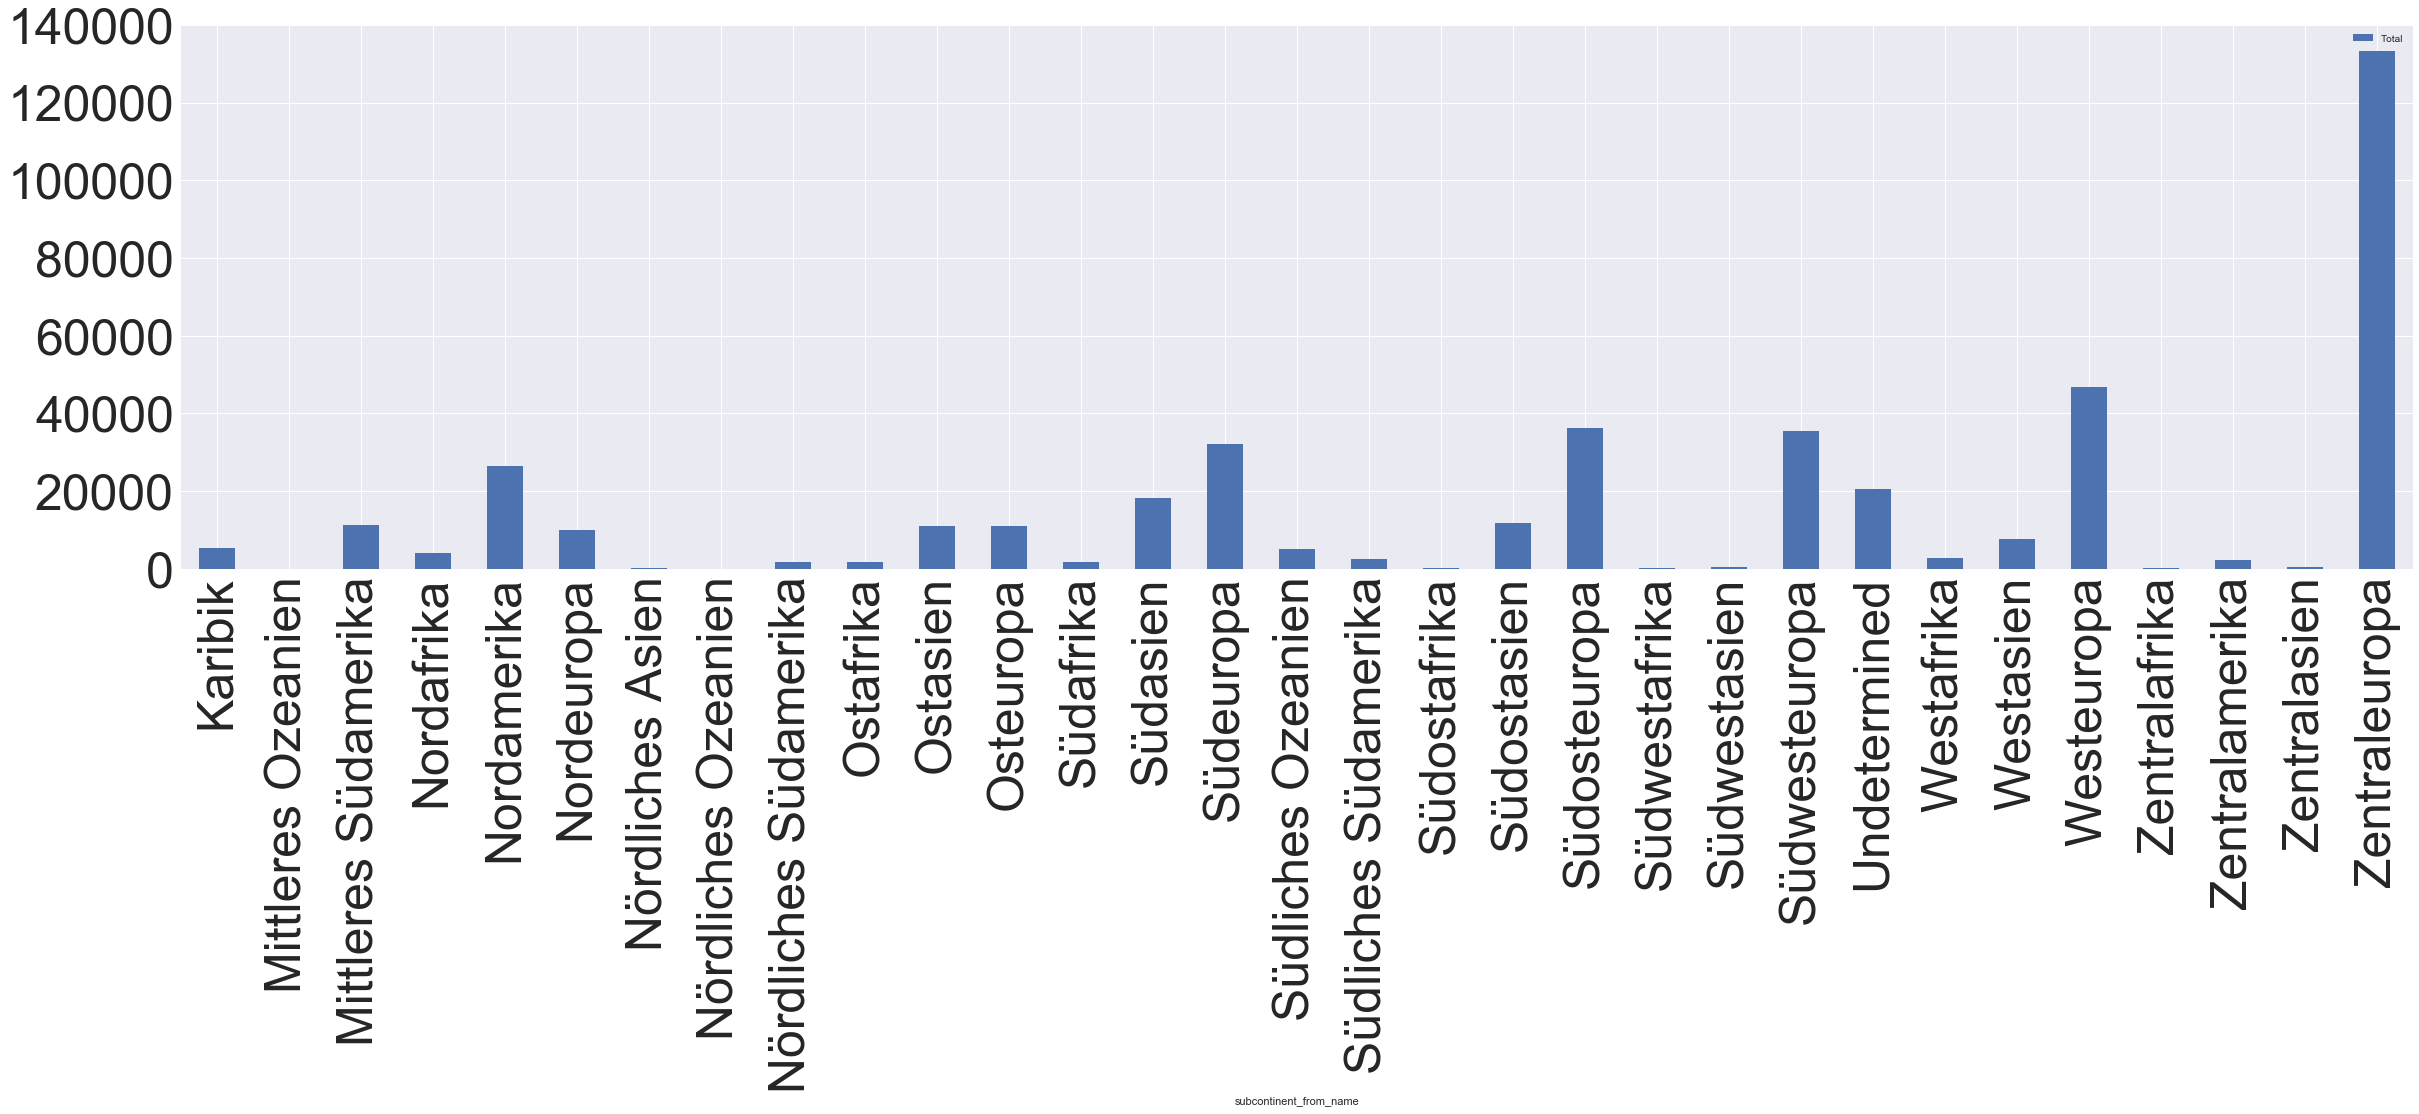

In [15]:
# So let's look a where the forigeners come from :)
subcontinent = ZH_in_df[ZH_in_df.country_from_name != 'Schweiz']
subcontinent = df_subset_total(subcontinent, ['subcontinent_from_name'], 'Total')
subcontinent.plot.bar(x='subcontinent_from_name',figsize=(40,10),fontsize=50)

In the bar plot above we notice that most of the incoming people are from Europe and in particular Central Europe. Therefore have we for now devided these into 3 groups: Swiss, European and Non-European.

In [19]:
# This is a function that given the year, y, and the nationality (Swiss, European or Non-European), returns a dataframe
# with ratio of people moving in to the diffrent district compared to how many already lives there for the respective
# year and nationality

def year(y,nationality):
    # Creats a dataframe of ZH_in_df where only the rows with Year y is kept
    ZH_in_df_year = ZH_in_df[ZH_in_df.Year == y]
    #Rest index of this dataframe
    ZH_popul_year = ZH_popul[ZH_popul.Year == y].reset_index()
    # Creat a dataframe of the above but this time we only keep the Swiss citizen
    ZH_in_df_swiss = ZH_in_df_year[ZH_in_df_year.country_from_name == 'Schweiz']
    # Creat a datafram with on non swiss citizen
    ZH_in_df_non_swiss = ZH_in_df_year[ZH_in_df_year.country_from_name != 'Schweiz']
    # New dataframe where we save the results of the ratios later, and we only keep the disticts name.
    ZH_in_precentage1 = df_subset_total(ZH_in_df_non_swiss, ['Year','district_to_name'], 'Total')
    
    ZH_in_precentage = ZH_in_precentage1[['district_to_name']]
    # If nationality is Swiss calculate the above explained ratio
    if nationality == 'Swiss':
        
        ZH_popul_CH_year =  ZH_popul_CH[ZH_popul_CH.Year == y]

        ZH_popul_CH_year_swiss = ZH_popul_CH_year[ZH_popul_CH_year.CH_nonCH == 'Swiss'].reset_index()
        
        ZH_in_df_swiss_year = df_subset_total(ZH_in_df_swiss, ['Year','district_to_name'], 'Total')
        
        ZH_in_precentage['Total'] = ZH_in_df_swiss_year['Total']/ZH_popul_year['Total']*100
        
        #ZH_in_precentage['Swiss'] = ZH_in_df_swiss_year['Total']/ZH_in_df_swiss_year['Total'].sum()*100
        
    # If nationality is European calculate the above explained ratio         
    elif nationality == 'European':
        
            ZH_in_df_europa = ZH_in_df_non_swiss[ZH_in_df_non_swiss.continent_from_name == 'Europa']
            
            ZH_in_df_europa_year = df_subset_total(ZH_in_df_europa, ['Year','district_to_name'], 'Total')
            
            ZH_in_precentage['Total'] = ZH_in_df_europa_year['Total']/ZH_popul_year['Total']*100
            
            #ZH_in_precentage['European'] = ZH_in_df_europa_year['Total']/ZH_in_df_europa_year['Total'].sum()*100
     # If nationality is Non-European calculate the above explained ratio 
    elif nationality == 'Non-European' :
            
            ZH_in_df_world = ZH_in_df_non_swiss[ZH_in_df_non_swiss.continent_from_name != 'Europa']
        
            ZH_in_df_world_year = df_subset_total(ZH_in_df_world, ['Year','district_to_name'], 'Total')
    
            ZH_in_precentage['Total'] = ZH_in_df_world_year['Total']/ZH_popul_year['Total']*100
    # If the wrong attributes are called
    else :
        
        return 'Not a valid year or Nationality'
  
    return ZH_in_precentage

In [20]:
#Function that plots the choropleth map
import folium
import branca.colormap as cms
#linear = cm.LinearColormap(['green', 'yellow', 'red'],vmin=0, vmax=16)
linear = cms.linear.RdBu.to_step(20).scale(0, 20)
list_of_scale = [0,1,2,3,4,5]
#linear.to_step(16)
def ploting(y,nationality) :
    data1 = year(y,nationality)
    zurich_geo_path = r'Data/ZH_district_geo.json'
    geo_json_data = json.load(open(zurich_geo_path))
    
    zh_map = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
    
    zh_map.choropleth(geo_data=geo_json_data, data=data1,
             columns=['district_to_name','Total'],
             key_on='feature.properties.qname',
             fill_color='RdBu',
             legend_name='Percentage of ' + nationality + ' moving in compared to district population')
   
    return zh_map

In [21]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider

# Creat a slider widget for changeing the year
a_slider = IntSlider(min=1993, max=2016,step=1)
#Interact calls the ploting function with the widget values and plots the new map
interact(ploting, y = widgets.IntSlider(min=1993, max=2016,step=1), nationality = ['Swiss','European','Non-European'] )


<function __main__.ploting>

From the map we can see that there are a higher percentage of people moving in to the central district compared to have many people are living in the diffrent districts. What to be noticed is that the range in the scale chages over the years, therefore it can be a bit hard to compare the diffrent maps but it still gives a good understanding where the moving ratios are the highets compared to have many are already living in the district. For the next milestone the scale will be the same for all maps.

If we compare the Swiss, European and Non-european the moving patterns are quite similar with only a few differences. It seems like Non-european prefer central Zurich but also the northern district. The swiss as well as the Europeans prefer the center and the closest district.

# Tasks until Milestone 3

## District to district (D2D) analysis of people moving within

We start with a general analysis of the numbers of moves between disricts (all years). Depending on the specific questions we can later fine grade the analysis by gender or age groups.

### Task 1 -  D2D influx analysis Level 1

First we calculate for each district (district_to) the total number of people moving within ZH (regardless of original district) to this district and measure this against the population of that district as a percentage.

Second we calculate for each district (district_to) the total number of people moving within ZH to this district and compare this with the expected distribution if we randonly selected a representative sample of the moving to that district. This will allow us to measure whether a district is attractive/or not for people from the other districts. We can perform a similar analysis for the original district and see which target districts are more attractive than random chance.

These above metrics give us a willingness to move to / away from this district. Note that the two rates are not exclusive as different demographics of people may move in compared to those moving out.

### Task 2 -  D2D influx analysis Level 2

We calculate for each district (district_to) the  profile of the number of people coming from different districts and represent these in percent. In effect, this gives us a probability distribution for the original district (district_from). We then compare this against the probability profile representing the overall population. 

There are two ways to do the latter. One we take a straight difference (i.e. 50 more/less than expected came from district A), or we take a ratio (i.e. 20% more/less than expected came from district A). Observe that the second is close to performing chi-square goodness of fit tests which use (O-E)^2/E.

We can also reverse the focus and look at probability distribution for the destination district.

### Task 3 -  Create interactive maps

Above we created an interactive map that allows the user to select the class of data that s/he would like to display and change the year on the slider. We aim to generate this visualisation for some of the data we have analysed so far. We could add specific examples where contrast different subgroups of the population. 

We could also connected the maps with our D2D analysis above, by creating an interactive map in which the user selects their current district and is given the likelihoods for moving into other districts.

### Task 4- option 1: Machine Learning Question:

If I know your gender, age and marital status and I know you moved to district D in year Y. Can I correctly predict whether before that 

**a)** you lived somewhere in Zurich, or 

**b)** you moved to Zurich from the outside. 

We will split the data in a 90%-10% ratio to create training and test sets. We will for the training data we will use k-fold cross-validation to make the learning process more robust. We then set up a machine learning algorithm that aims to predict whether it should be option a) or option b). We will evaluate our machine learning algorithm with the help of the test set. 

### Task 4- option 2: Storyline (simulations)

It is 1993, you are 18, and you are about to move to Zurich.

Your plan for the next 25 years is to:

1) Study/work in Zurich

2) be married at the age of 27

3) have children from the age of 32.

Speed forward to 2017: Where in Zurich will you live? How did your lives decisions influence your path? What difference would it make if you were male or female?

We will run simulations of the possible pathways through the years and Zurich's districts to generate a map that give us the probability distribution of our final destination district.

Option: We could include the possibilty that we may decide to leaving Zurich all together at some stage.

### Task 5 - Write a report

At this stage our intention is to write a report which will sunmmarise our methods, the analysis and the main observations. We will discuss our findings in the context of Zurich. The interactive maps will be hosted online to allow the reader to visualise trends and analyses.

We will also aim to highlight a couple of interesting/curious observations (which ones is to be decided) in some more details. This may be informed by the storyline simulations, of choose to work on that option.



#### Additional/alternative questions that could be considered


Examples: 

1) What are the top 3 destinations for people leaving a district for another in Zurich?

2) What are the top 3 origins for people coming to Zurich from Switzerland respectively the rest of the world?
How does this change over time?

3) What districts have the highest portion of each age group or gender?

4) Version a) What districts have the the highest portion of singles/couples/widows? Tricky one: As we do not have absolute numbers for marital status at district level.

4) Version b) What districts attract/lose the the highest portion of singles/couples/widows? Tricky one: As we do not have absolute numbers for marital status at district level.

5) What districts have the highest/lowest percentage turn around?


## Pathway until the presentation

For the poster presentation we will either present our main observations or focus on 3-4 examples of ways in which neighbourhoods in Zurich changed and the associated moving patters. We may make our interactive maps available for the viewers.

If we opt for the storyline and are sufficiently successful, we may create the option for users to create their own profile in 1993 and create a potential path.



